### Business Goal:
Requirement is to model the demand for shared bikes with the available independent variables. It will be used by BoomBikes to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

To achieve this we need to perform below actions:
- Perform EDA on the available. 
- Prepare data to build model.
- Train the model and evaluate results. 
- Verify the model against the test data. 

#### Import the required libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

In [72]:
import statsmodels.api as sm

### Exploratory Data analysis
This section includes cleanup, data prep and analysis to determine which variables suit best to build our model

In [3]:
# Read the data from csv file
df = pd.read_csv('day.csv')

In [4]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

There are no columns that contain null values as observed in the above

In [5]:
# Dropping trivial columns
df_copy=df.drop(['casual','registered','dteday','instant'], axis=1)

In [6]:
df_copy.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


#### Creating Dummy variables out of categorical variables

In [18]:
df_copy['season'].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [19]:
# Creating dummy variables out of category 'season'; using drop_first=True to redundancy in the data.
season_cat = pd.get_dummies(df_copy['season'], drop_first=True, prefix='season')

In [20]:
season_cat.rename(columns={'season_2':'summer', 'season_3':'fall', 'season_4':'winter'}, inplace=True)
season_cat

,summer,fall,winter
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
725,0,0,0
726,0,0,0
727,0,0,0
728,0,0,0


In [21]:
df_copy['weathersit'].value_counts(normalize=True)*100

1    63.424658
2    33.698630
3     2.876712
Name: weathersit, dtype: float64

In [23]:
# Creating dummy variables out of category 'weathersit';
weathersit_cat = pd.get_dummies(df_copy['weathersit'], prefix='weather')

In [24]:
weathersit_cat.rename(columns={'weather_1':'Clear', 'weather_2':'Cloudy', 'weather_3':'Light Rain','weather_4':'Heavy Rain'}, inplace=True)
weathersit_cat

,Clear,Cloudy,Light Rain
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
725,0,1,0
726,0,1,0
727,0,1,0
728,1,0,0


In [25]:
df_copy['weekday'].value_counts()

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

In [28]:
# Creating dummy variables out of category 'weekday';
weekday_cat = pd.get_dummies(df_copy['weekday'], drop_first=True, prefix='Day')

In [29]:
weekday_cat

,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
0,0,0,0,0,0,1
1,0,0,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
725,0,0,0,1,0,0
726,0,0,0,0,1,0
727,0,0,0,0,0,1
728,0,0,0,0,0,0


In [32]:
# Creating dummy variables out of category 'mnth';
mnth_cat = pd.get_dummies(df_copy['mnth'], drop_first=True)

In [33]:
mnth_cat.rename(columns={2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}, inplace=True)
mnth_cat

,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,0,0,0,0,0,0,0,0,1
726,0,0,0,0,0,0,0,0,0,0,1
727,0,0,0,0,0,0,0,0,0,0,1
728,0,0,0,0,0,0,0,0,0,0,1


#### Concatenate the above create dummy variable sets with actual data set and drop the actual categorical columns

In [34]:
df_copy = pd.concat([df_copy,mnth_cat], axis = 1)
df_copy = pd.concat([df_copy,weekday_cat], axis = 1)
df_copy = pd.concat([df_copy,weathersit_cat], axis = 1)
df_copy = pd.concat([df_copy,season_cat], axis = 1)

In [39]:
df_copy = df_copy.drop(['mnth','weekday','weathersit','season'], axis=1)

In [41]:
df_copy.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Feb,Mar,...,Day_3,Day_4,Day_5,Day_6,Clear,Cloudy,Light Rain,summer,fall,winter
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,1,0,0,0,1,0,0,0,0,0


In [50]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   hum         730 non-null    float64
 6   windspeed   730 non-null    float64
 7   cnt         730 non-null    int64  
 8   Feb         730 non-null    uint8  
 9   Mar         730 non-null    uint8  
 10  Apr         730 non-null    uint8  
 11  May         730 non-null    uint8  
 12  Jun         730 non-null    uint8  
 13  Jul         730 non-null    uint8  
 14  Aug         730 non-null    uint8  
 15  Sep         730 non-null    uint8  
 16  Oct         730 non-null    uint8  
 17  Nov         730 non-null    uint8  
 18  Dec         730 non-null    uint8  
 19  Day_1       730 non-null    u

#### Univariate Analysis

In [47]:
num_cols = ['temp','atemp','hum','windspeed','cnt']

In [51]:
cat_cols = ['yr' ,'holiday','workingday','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Day_1','Day_2','Day_3','Day_4','Day_5','Day_6','Clear','Cloudy','Light Rain','summer','fall','winter']

In [45]:
df_copy[num_cols].describe(percentiles=[0.25,0.5,0.75,.9,.99])

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
90%,29.998347,33.908210,81.762500,19.833997,7293.800000
99%,33.868050,38.941650,92.795857,27.380948,8163.810000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


Insights on temparatures:

- The Mean and Median(50th percentile) are almost same, and the variation across percentiles is not drastic indicating symmetric distribution of temperatures over these 2 years.
- Even though there is a difference between actual temperature and feeling temperature, feeling temperature also seems to be distributed normally.
- The minimum temperature observed is 2.42 celsius
- The maximum temperature observed is 35.32 celsius



In [46]:
len(df_copy[df_copy['windspeed']>=27.38])

8

Insights on windspeed:

- The minimum speed is 1.5 and maximum speed is 34
- 90% of the days the speeds are below 19

#### Bivariate Analysis

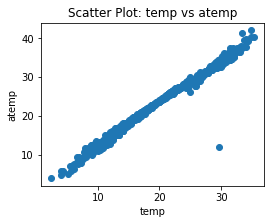

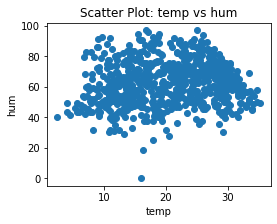

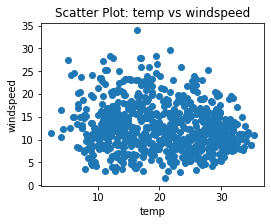

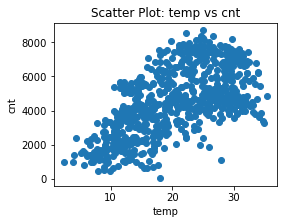

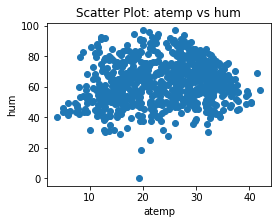

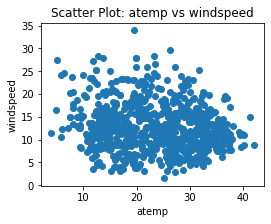

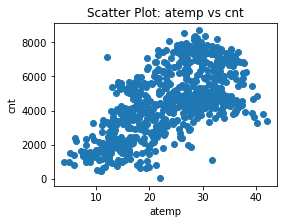

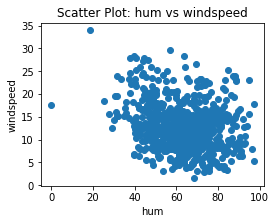

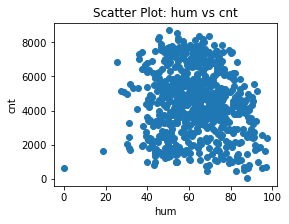

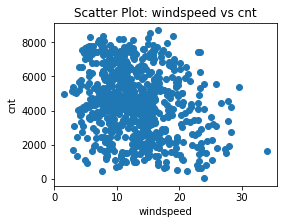

In [49]:
for i in range(len(num_cols)):
    for j in range(i + 1, len(num_cols)):
        plt.figure(figsize = (4,3))
        plt.scatter(df_copy[num_cols[i]], df_copy[num_cols[j]])
        plt.xlabel(num_cols[i])
        plt.ylabel(num_cols[j])
        plt.title(f'Scatter Plot: {num_cols[i]} vs {num_cols[j]}')
        plt.show()

Insights:
- There seems to be a positive correlation between actual temperature and feeling temperature. 
- There seems to be a negative correlation between humidity and windspeed, as humidity increases windspeed seems to be decreasing.
- There seems to be a positive correlation between feeling temperature and count of bikes shared, as the temperature increases the count increases.
- There seems to be negative correlation between humidity and count of bikes shared, as the humidity increases count decreases.
- There seems to be negative correlation between windspeed and count of bikes shared, as the windspeed increases count decreases.
- Other pairs do not show any correlation worth investigating

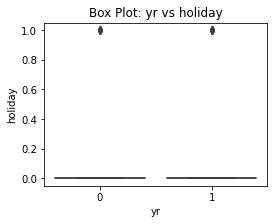

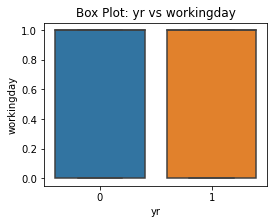

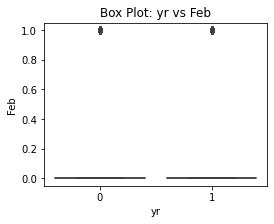

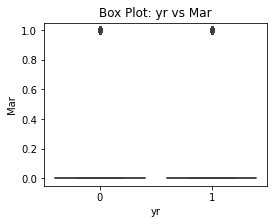

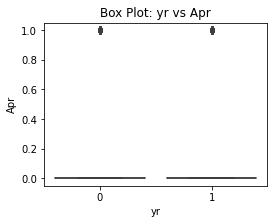

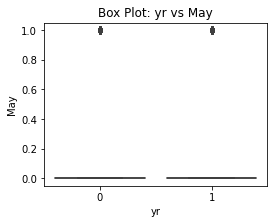

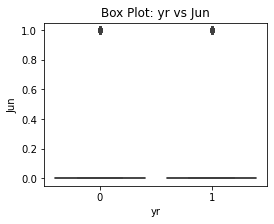

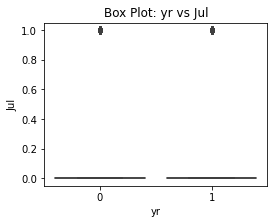

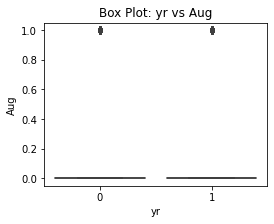

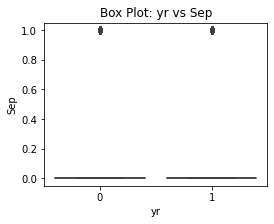

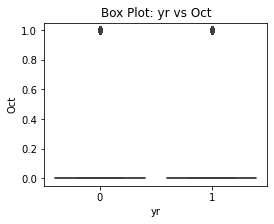

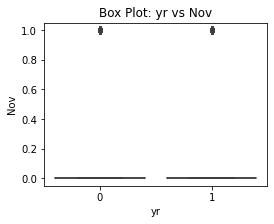

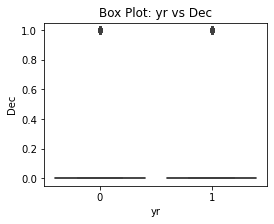

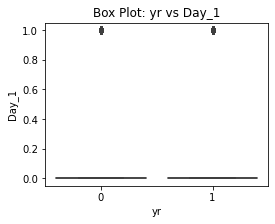

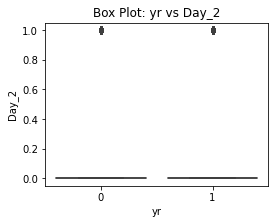

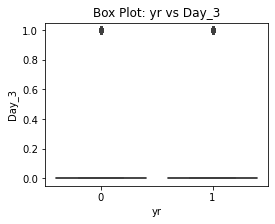

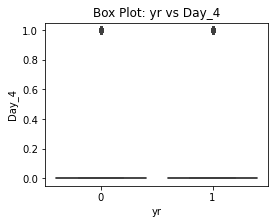

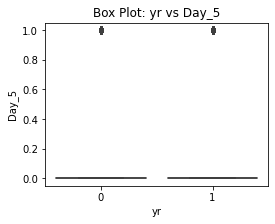

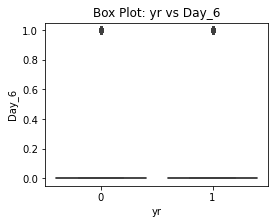

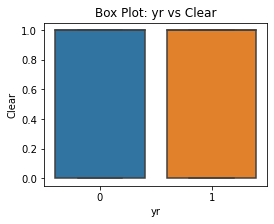

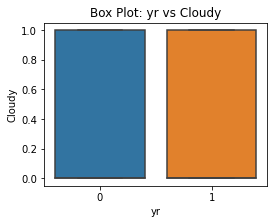

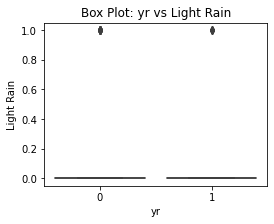

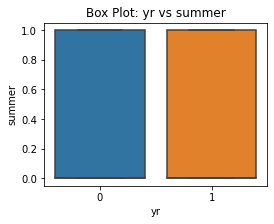

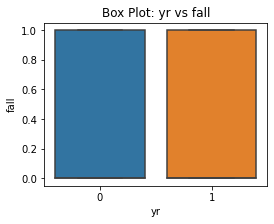

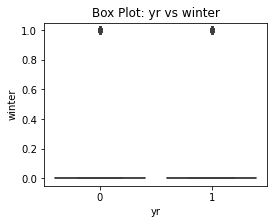

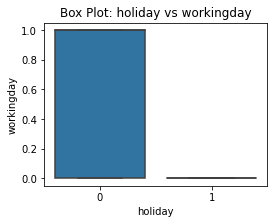

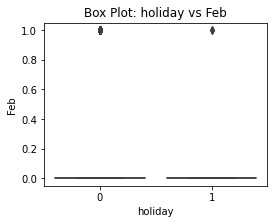

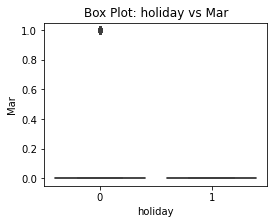

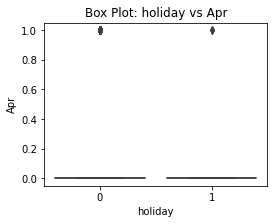

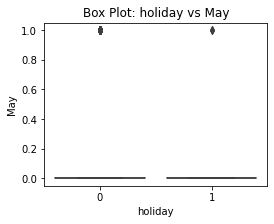

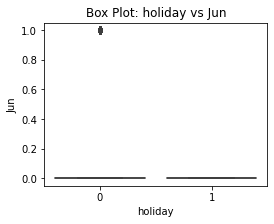

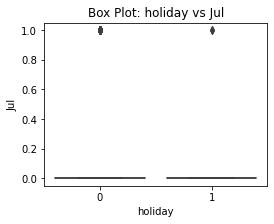

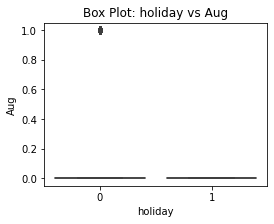

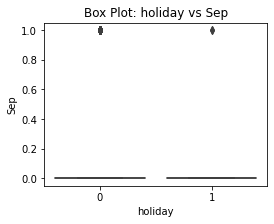

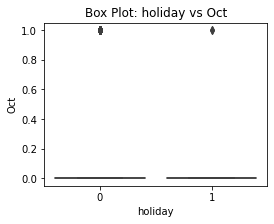

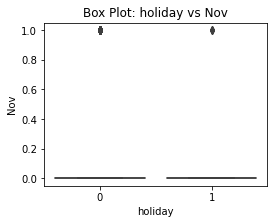

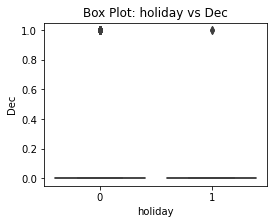

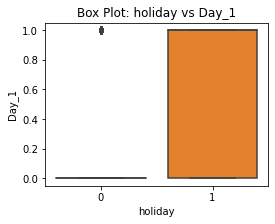

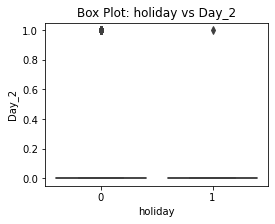

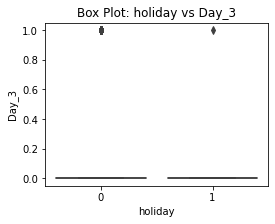

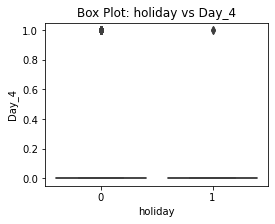

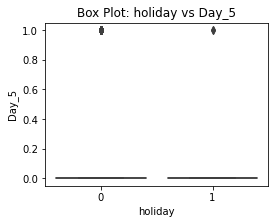

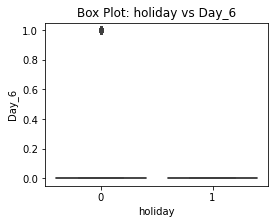

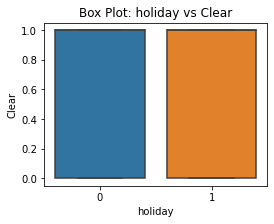

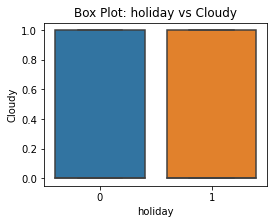

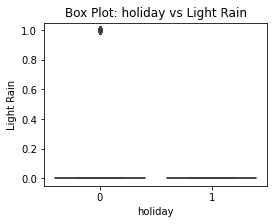

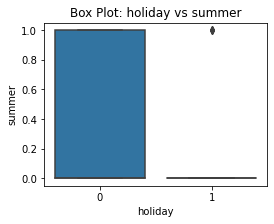

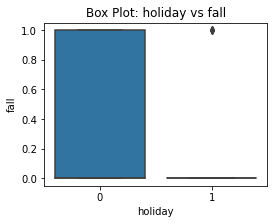

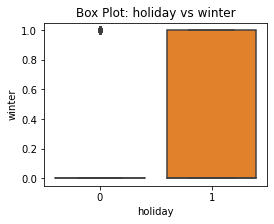

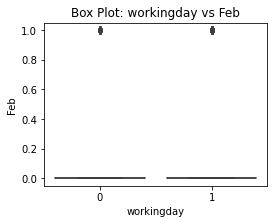

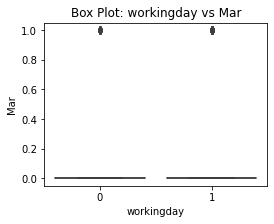

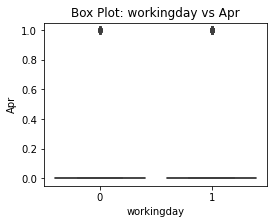

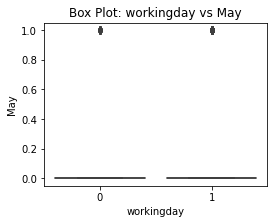

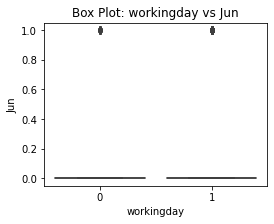

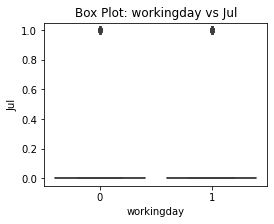

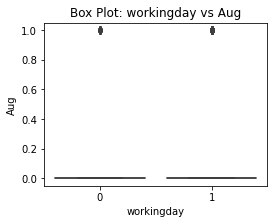

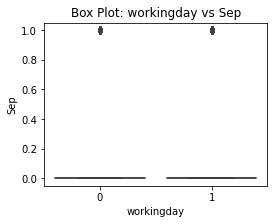

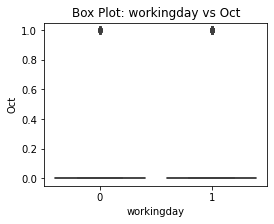

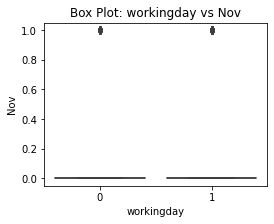

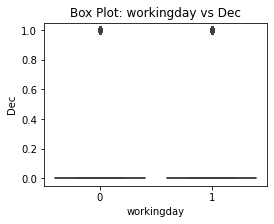

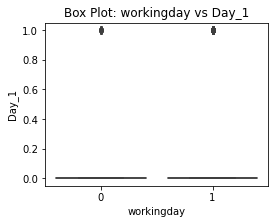

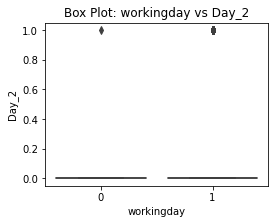

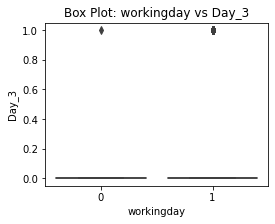

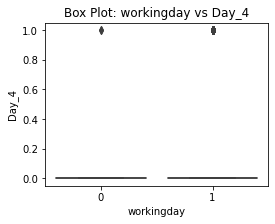

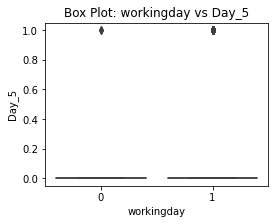

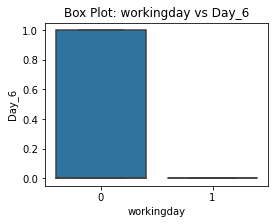

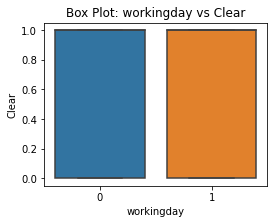

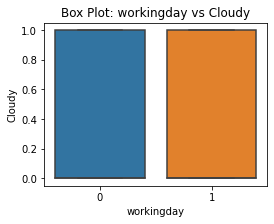

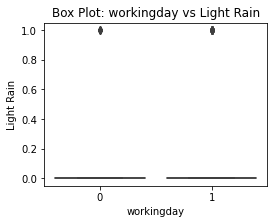

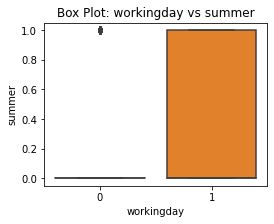

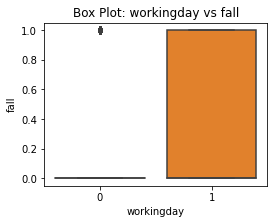

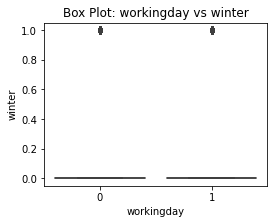

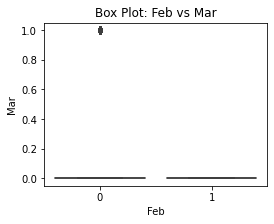

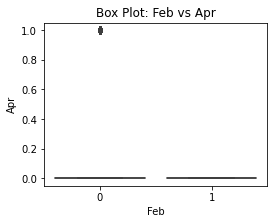

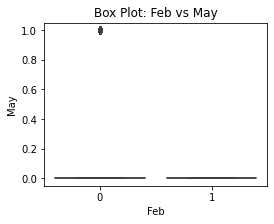

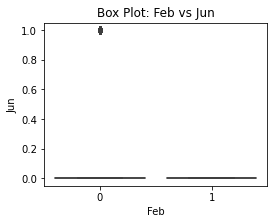

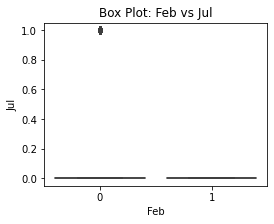

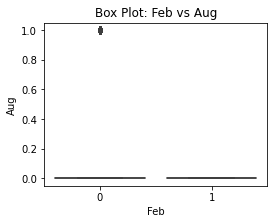

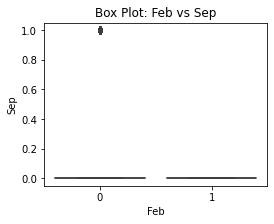

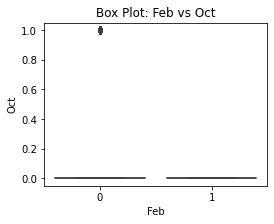

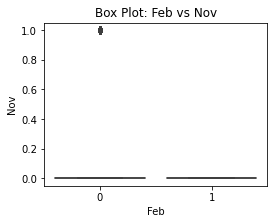

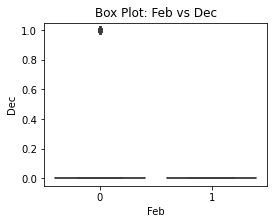

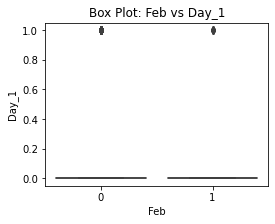

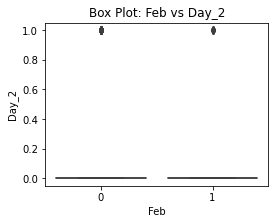

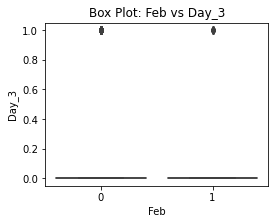

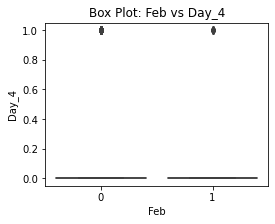

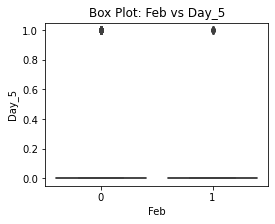

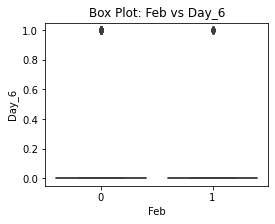

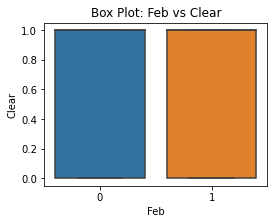

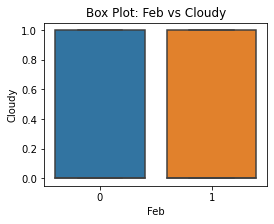

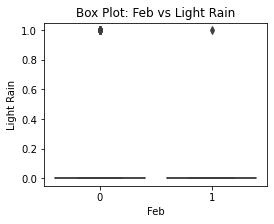

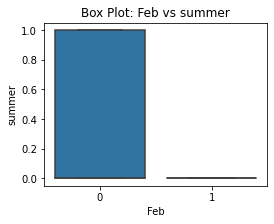

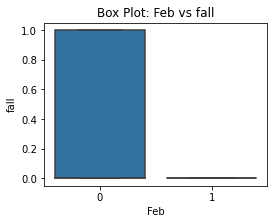

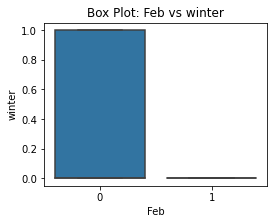

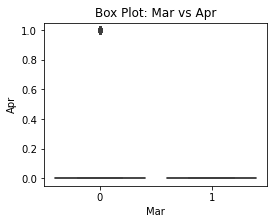

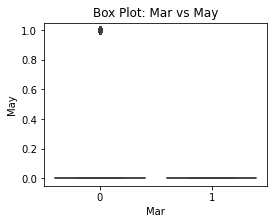

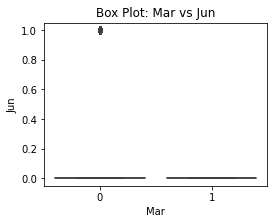

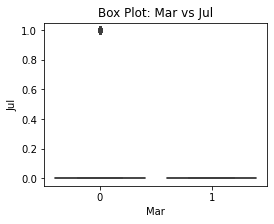

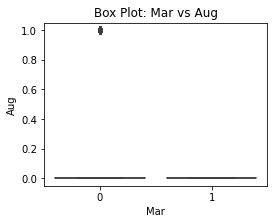

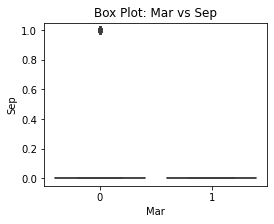

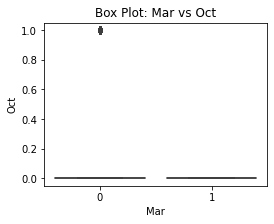

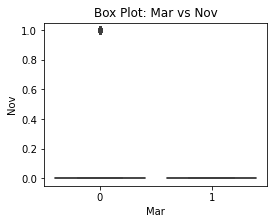

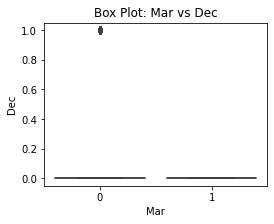

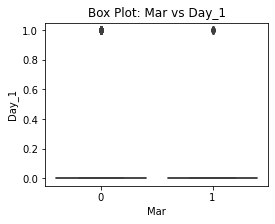

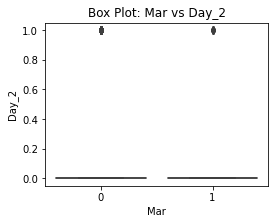

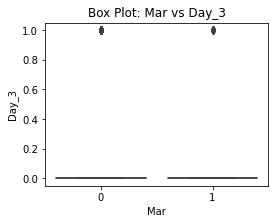

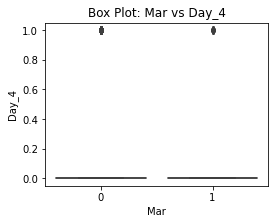

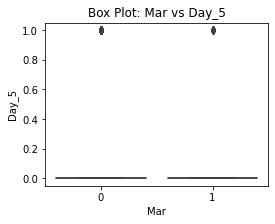

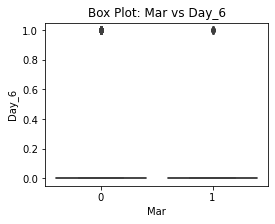

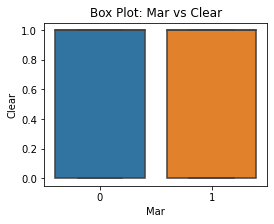

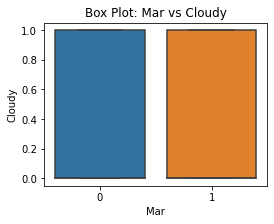

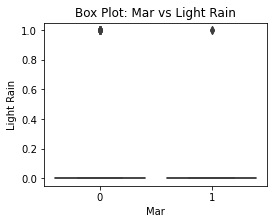

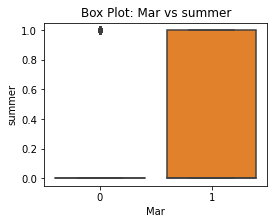

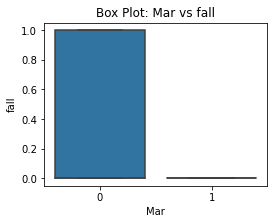

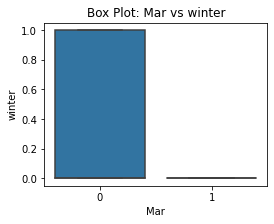

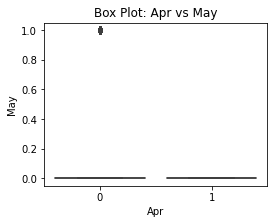

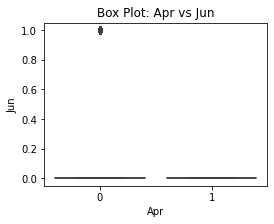

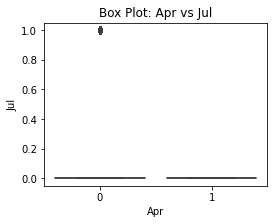

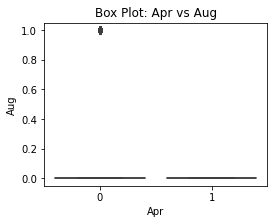

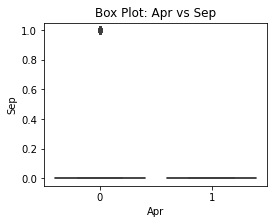

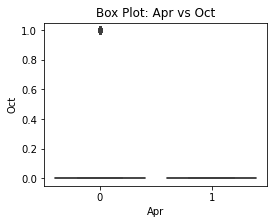

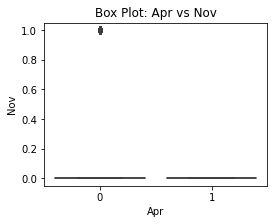

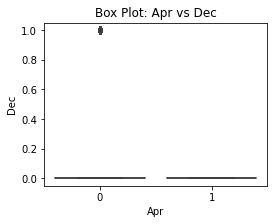

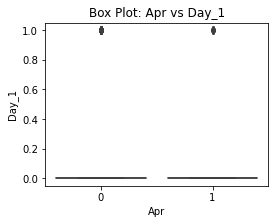

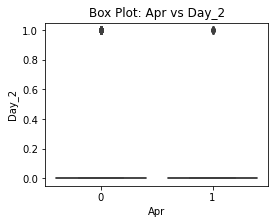

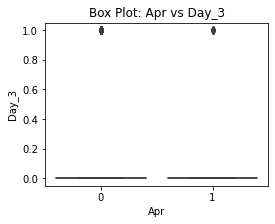

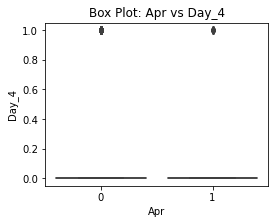

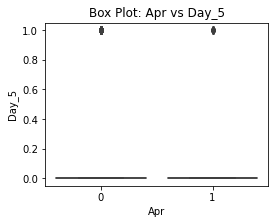

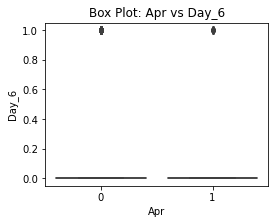

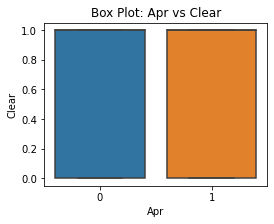

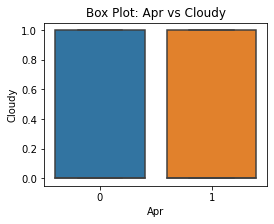

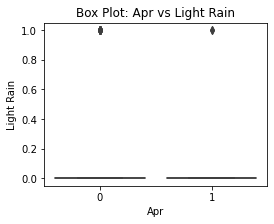

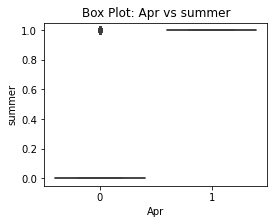

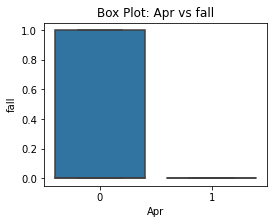

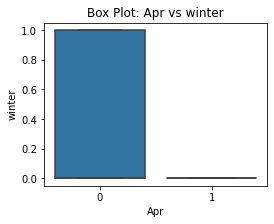

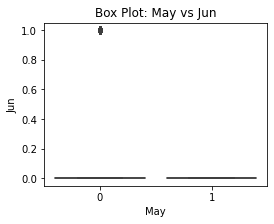

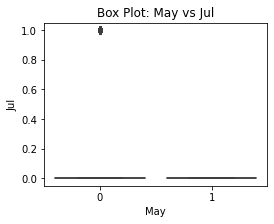

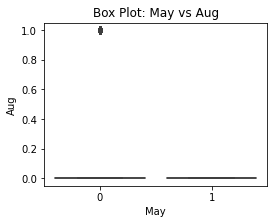

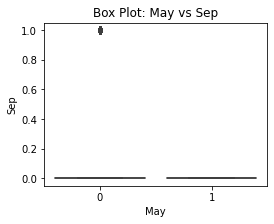

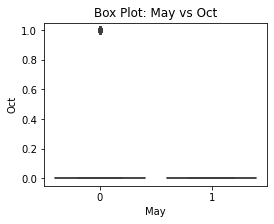

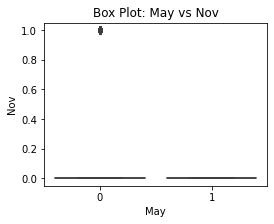

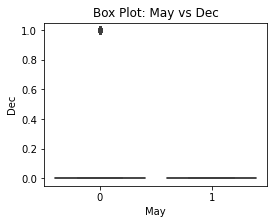

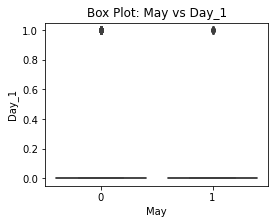

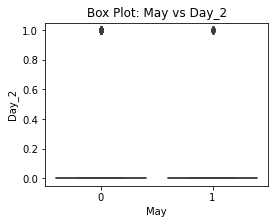

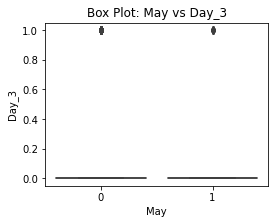

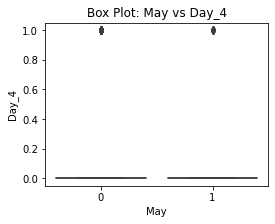

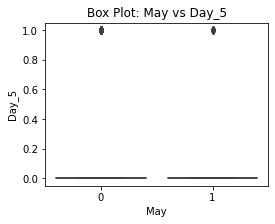

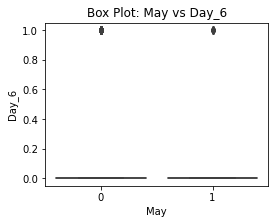

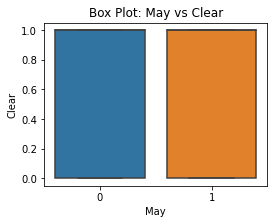

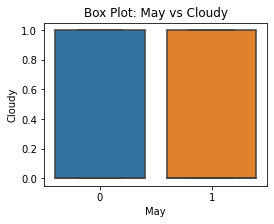

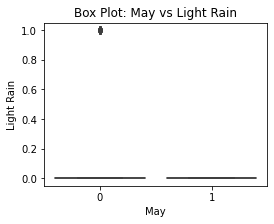

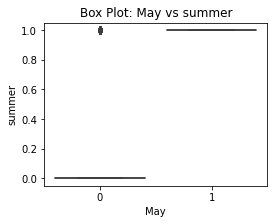

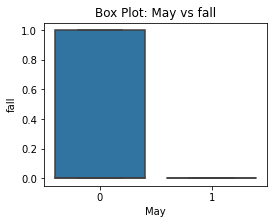

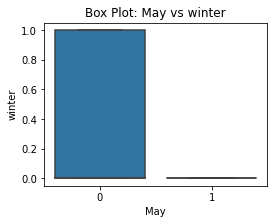

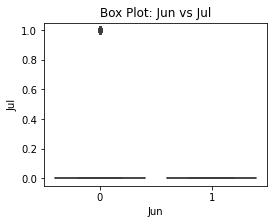

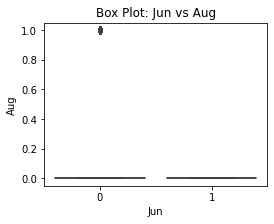

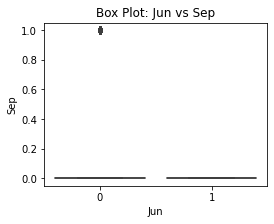

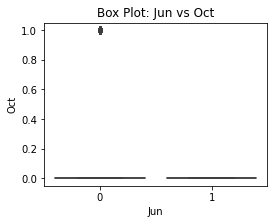

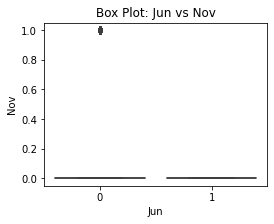

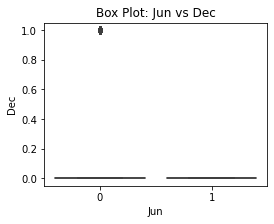

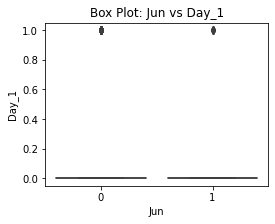

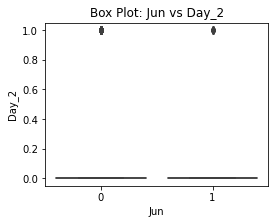

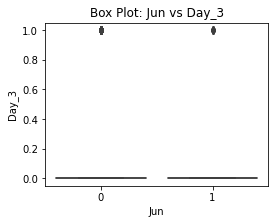

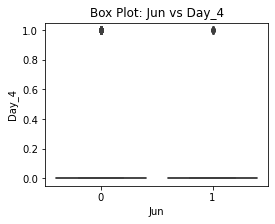

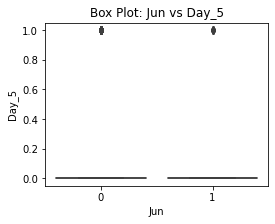

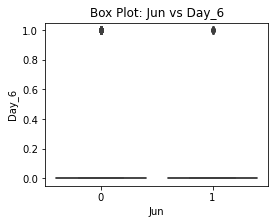

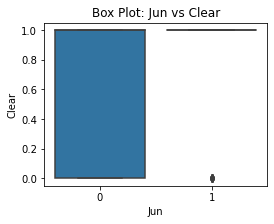

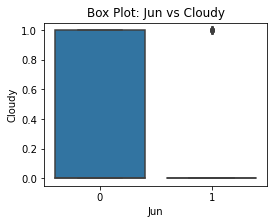

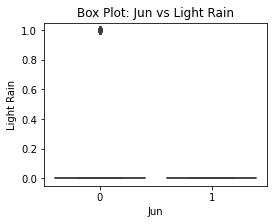

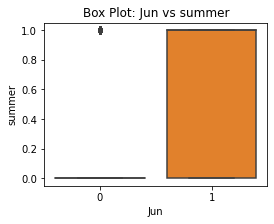

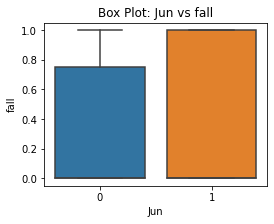

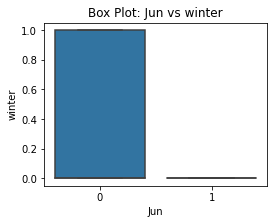

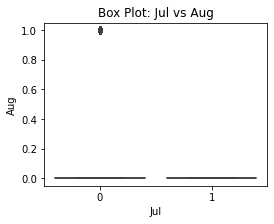

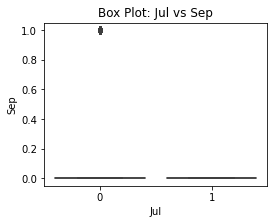

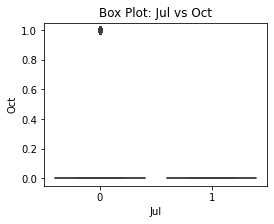

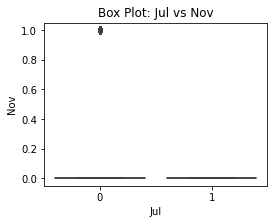

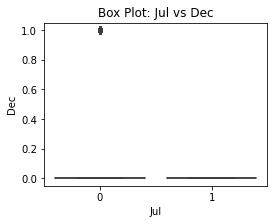

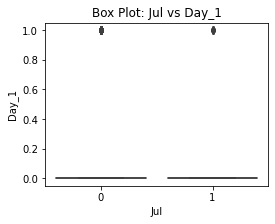

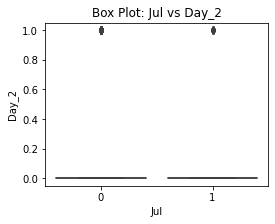

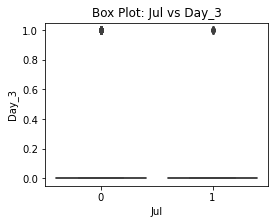

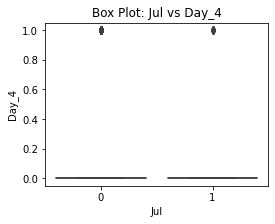

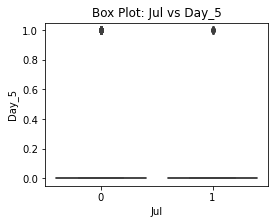

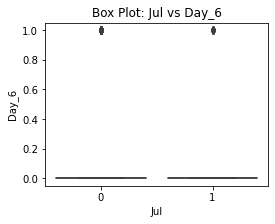

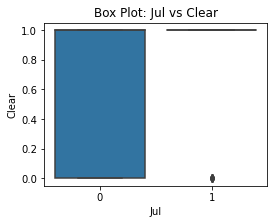

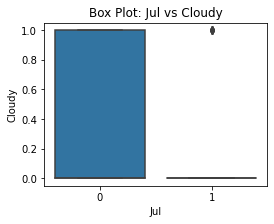

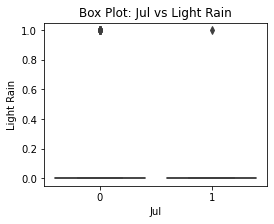

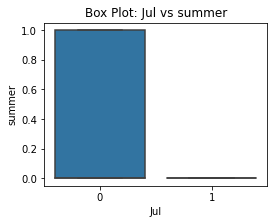

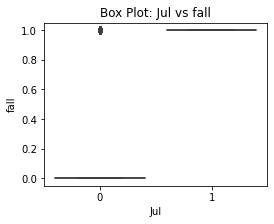

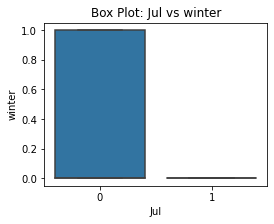

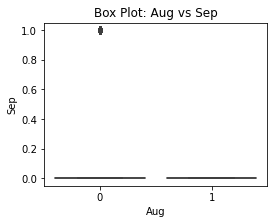

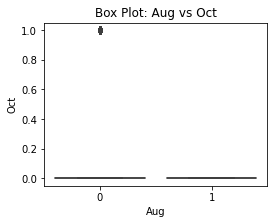

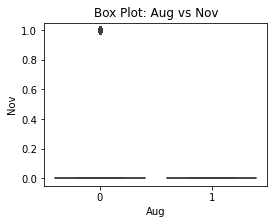

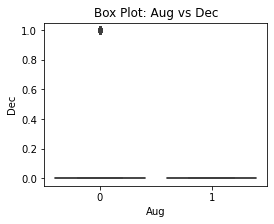

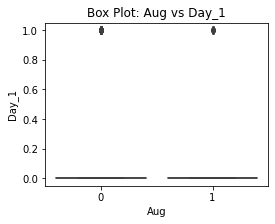

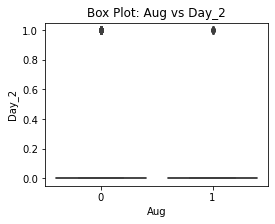

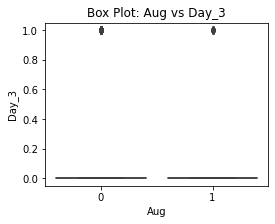

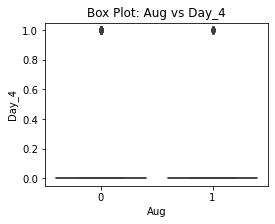

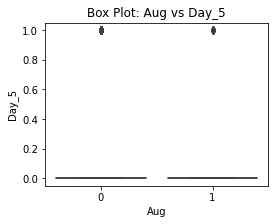

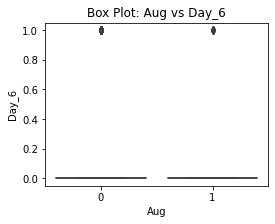

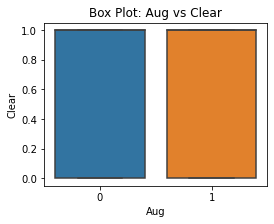

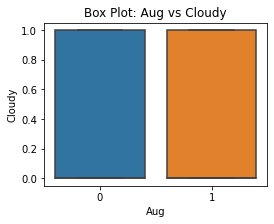

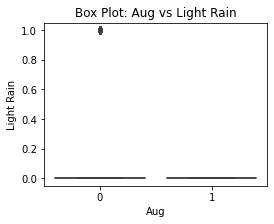

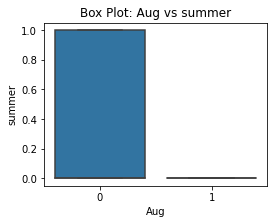

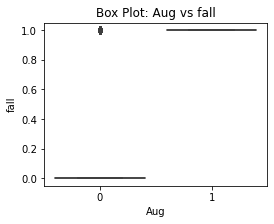

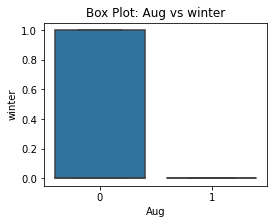

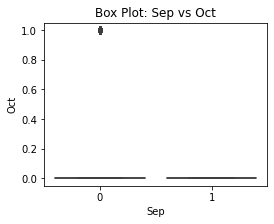

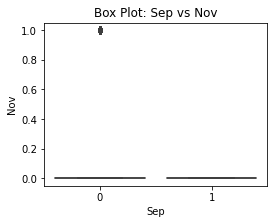

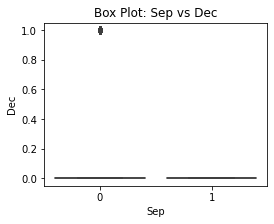

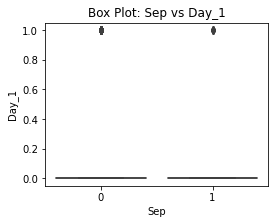

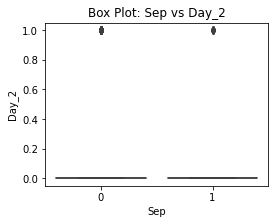

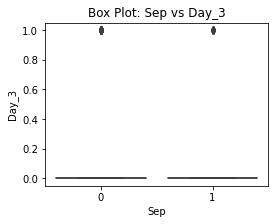

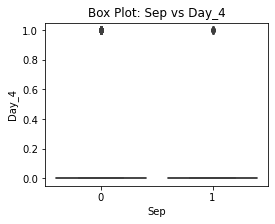

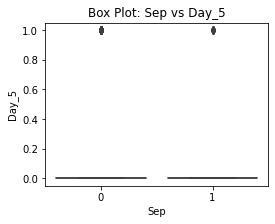

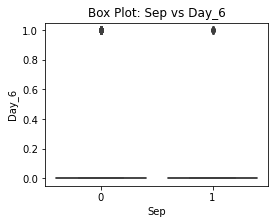

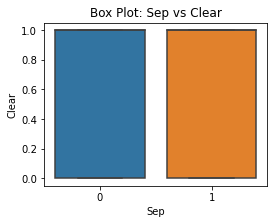

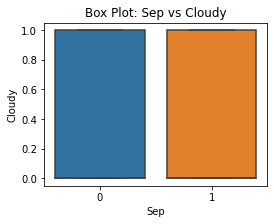

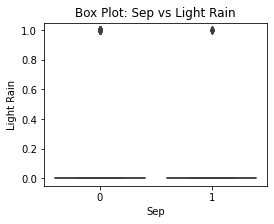

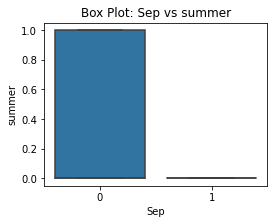

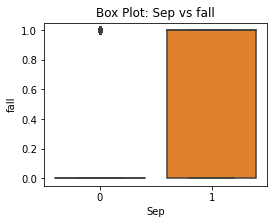

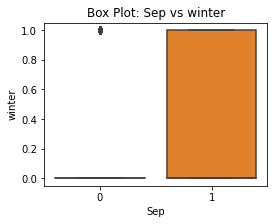

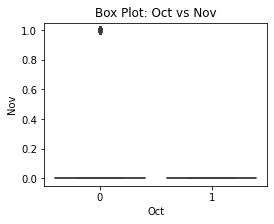

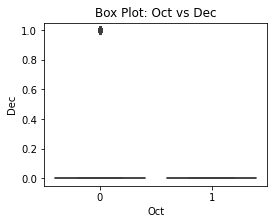

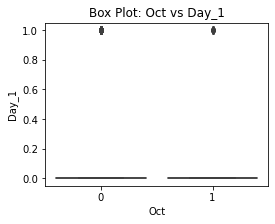

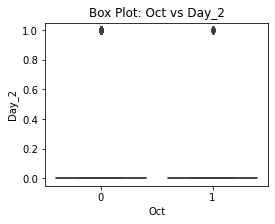

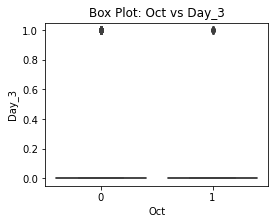

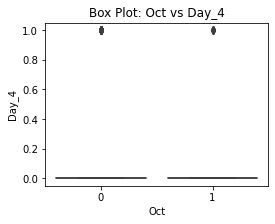

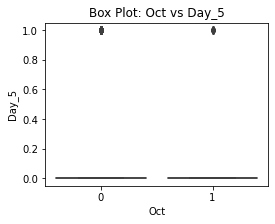

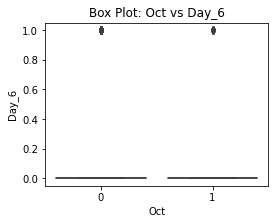

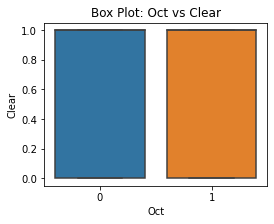

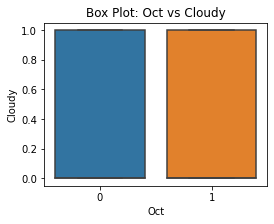

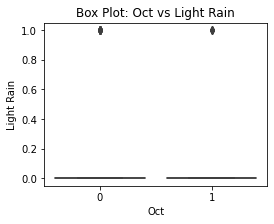

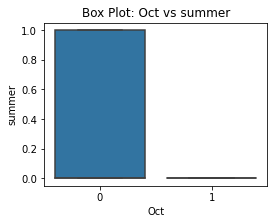

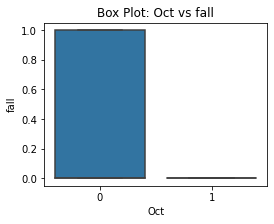

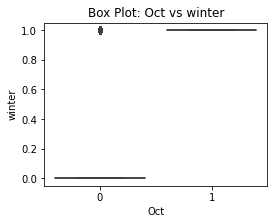

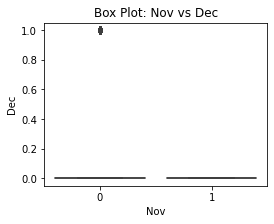

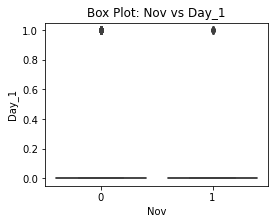

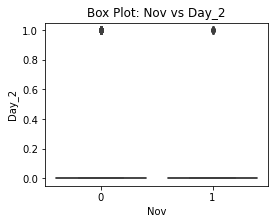

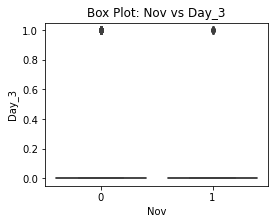

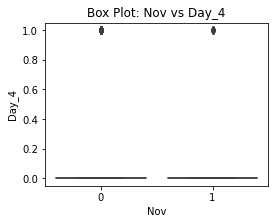

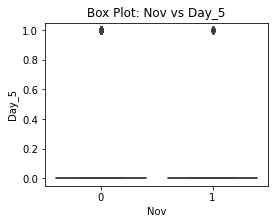

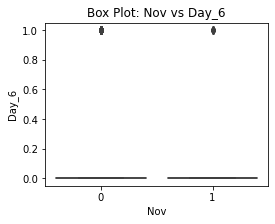

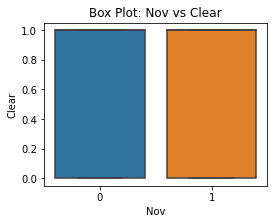

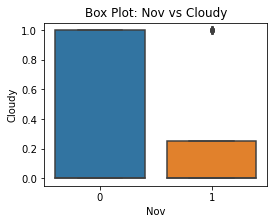

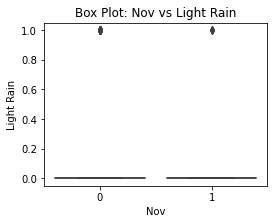

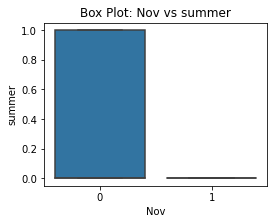

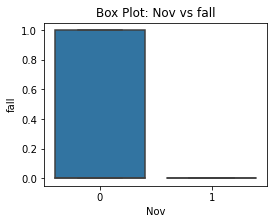

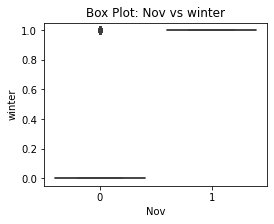

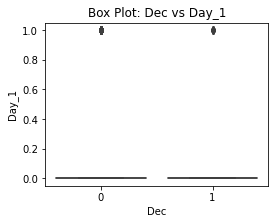

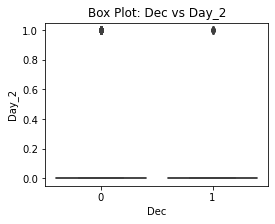

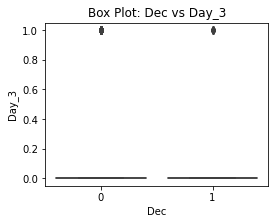

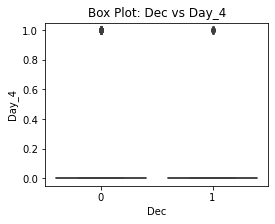

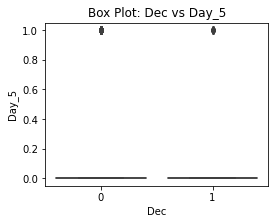

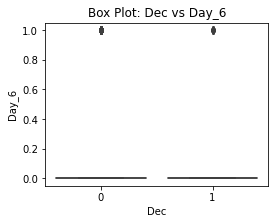

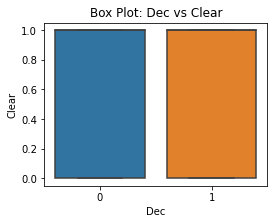

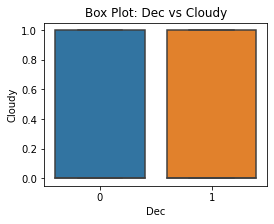

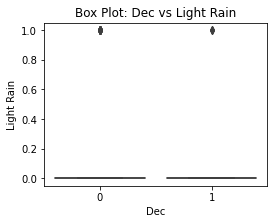

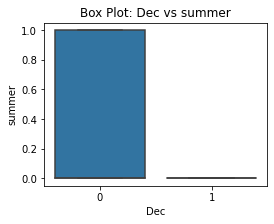

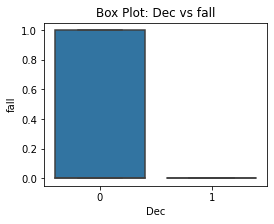

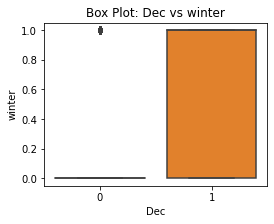

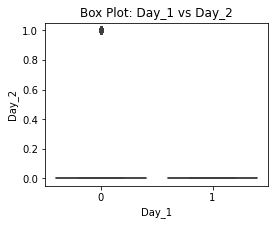

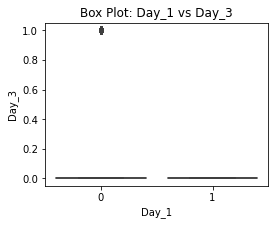

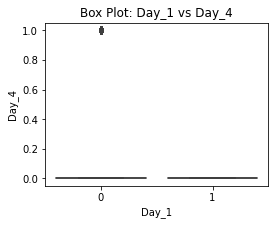

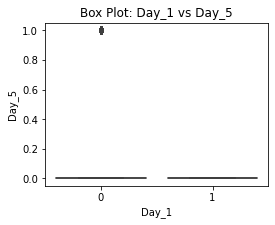

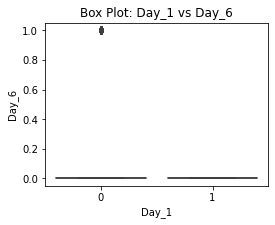

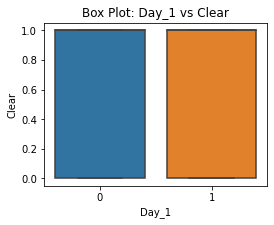

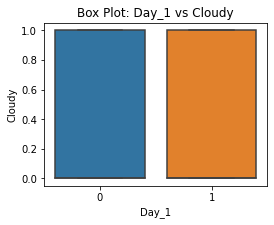

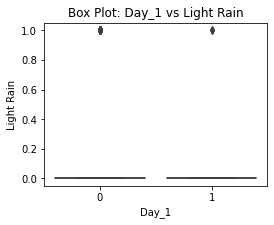

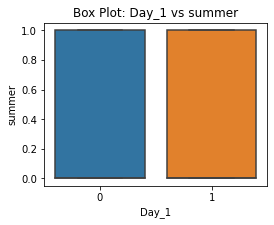

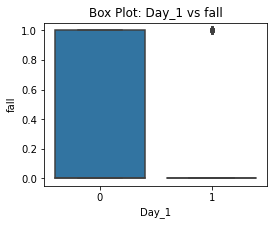

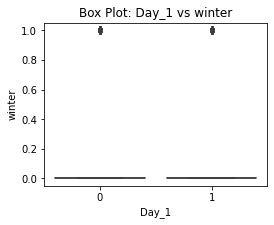

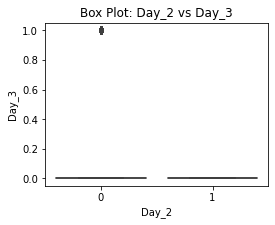

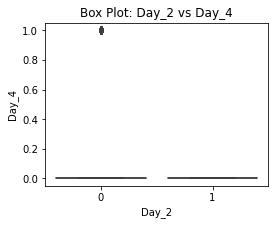

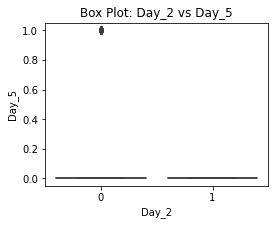

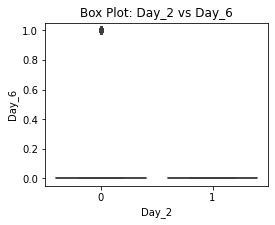

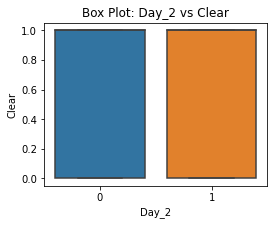

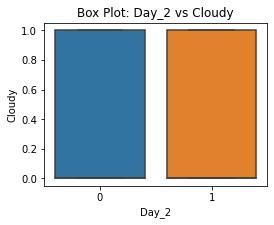

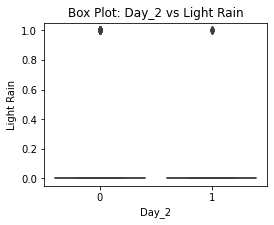

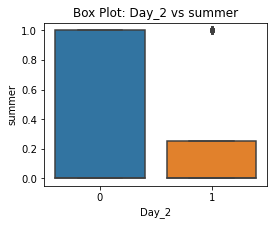

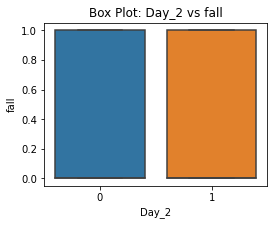

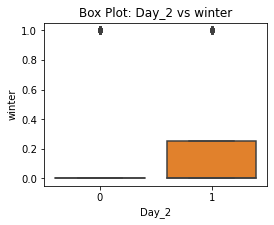

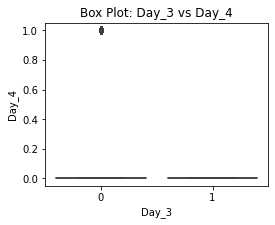

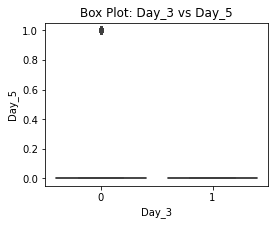

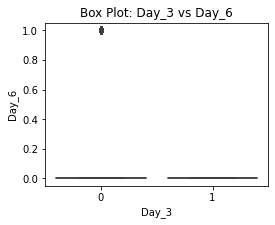

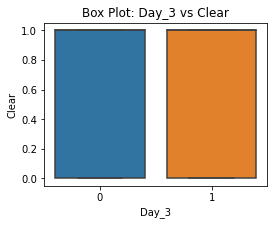

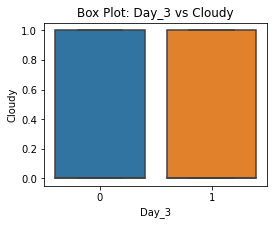

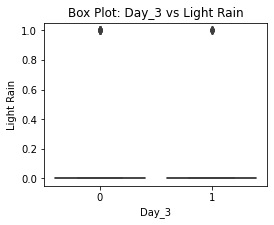

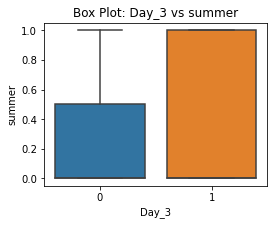

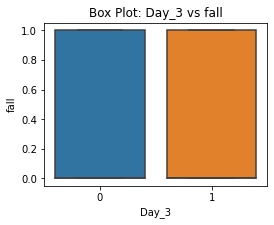

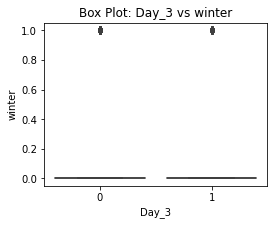

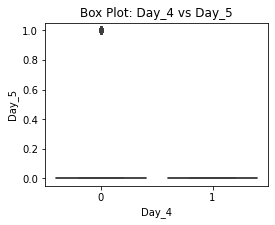

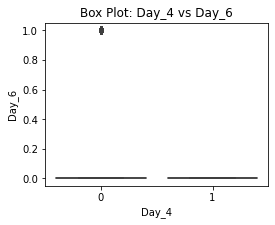

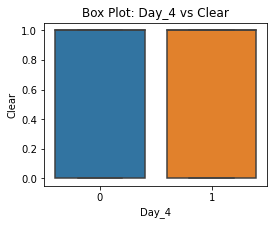

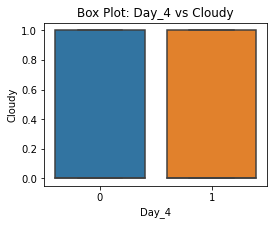

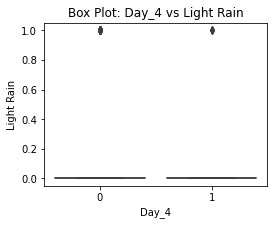

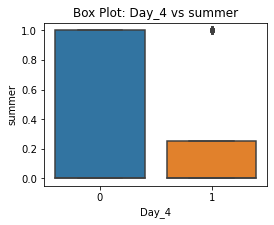

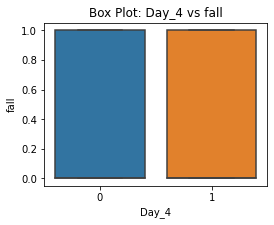

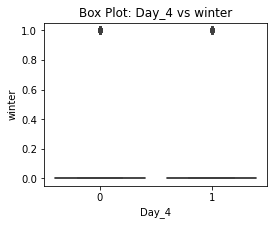

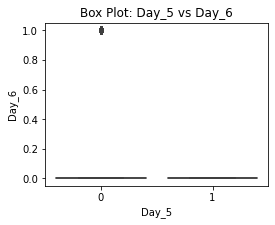

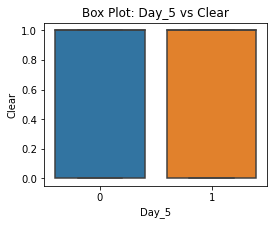

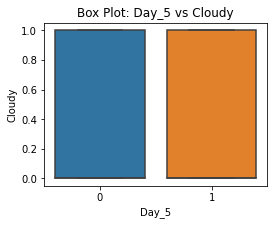

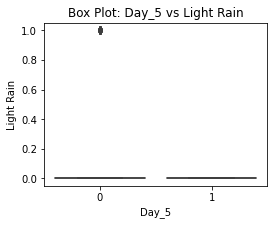

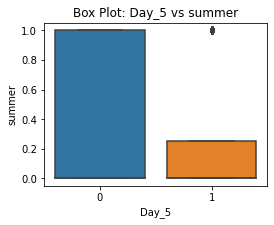

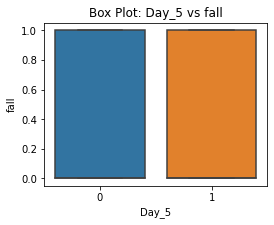

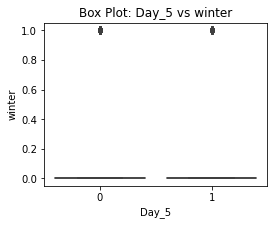

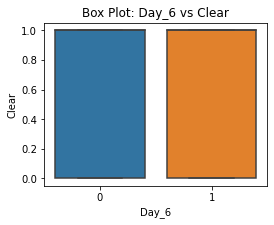

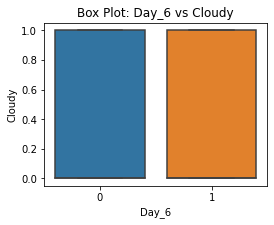

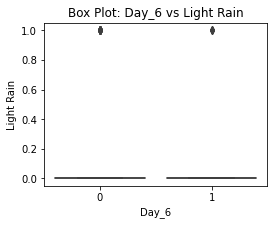

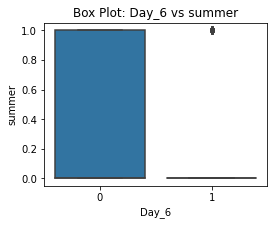

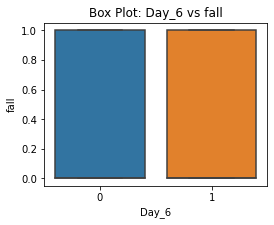

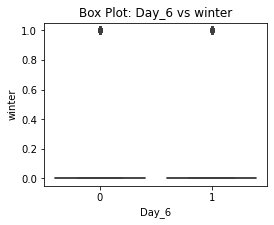

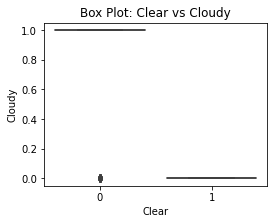

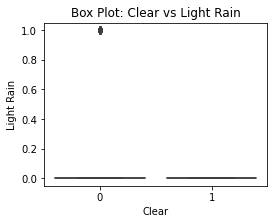

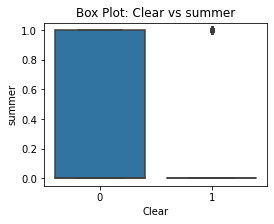

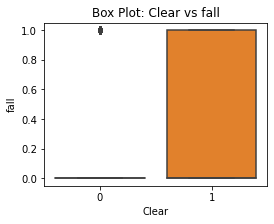

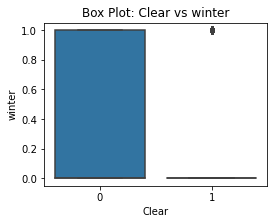

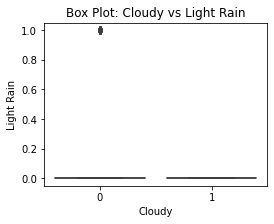

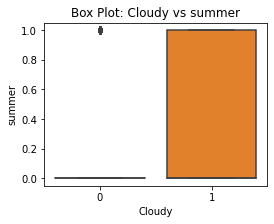

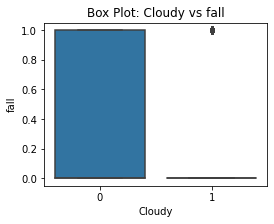

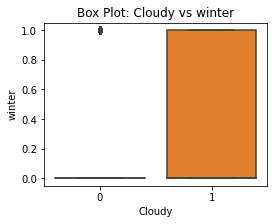

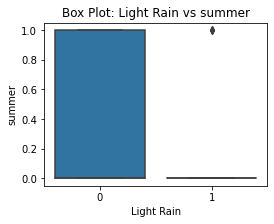

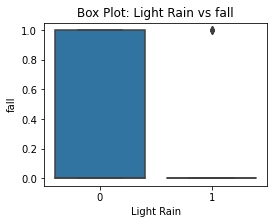

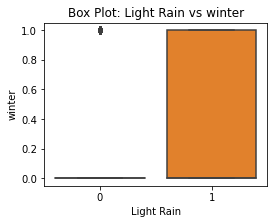

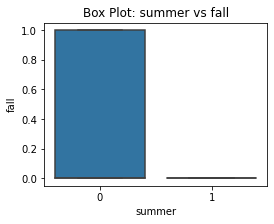

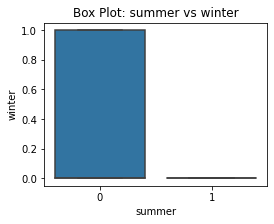

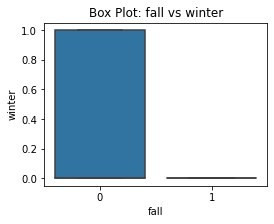

In [53]:
for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        plt.figure(figsize = (4,3))
        sns.boxplot(x=cat_cols[i], y=cat_cols[j], data=df_copy)
        plt.xlabel(cat_cols[i])
        plt.ylabel(cat_cols[j])
        plt.title(f'Box Plot: {cat_cols[i]} vs {cat_cols[j]}')
        plt.show()

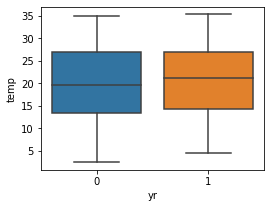

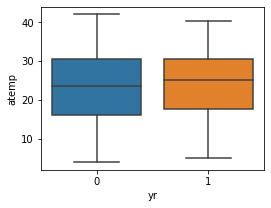

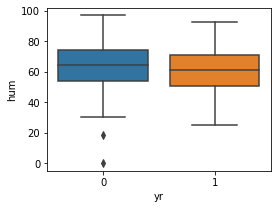

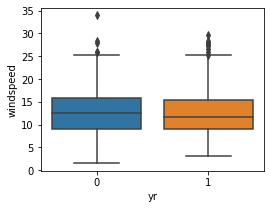

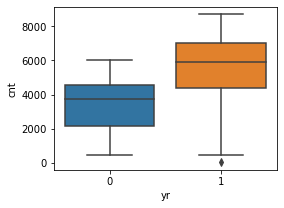

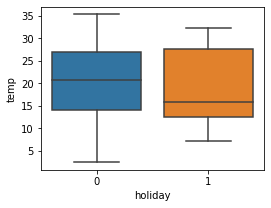

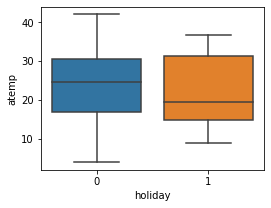

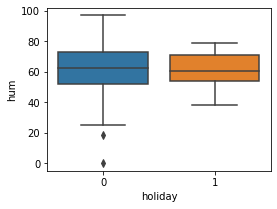

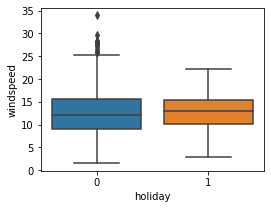

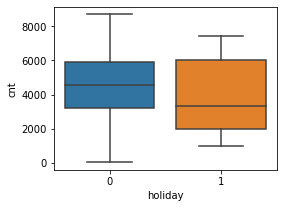

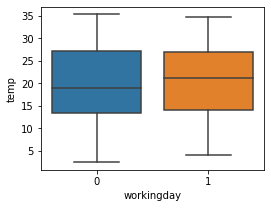

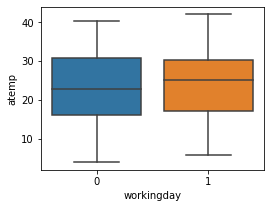

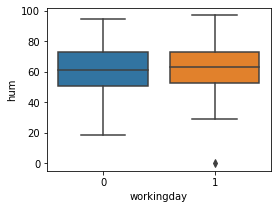

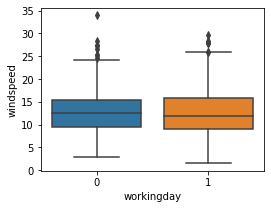

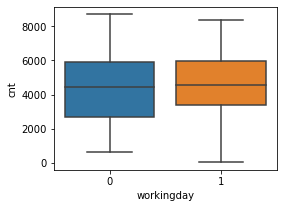

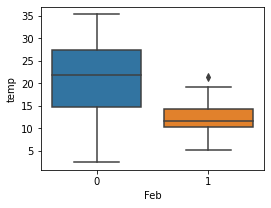

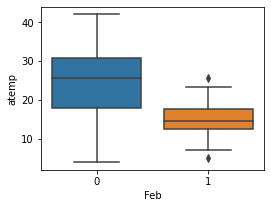

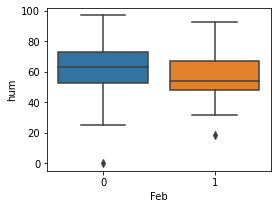

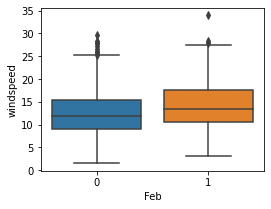

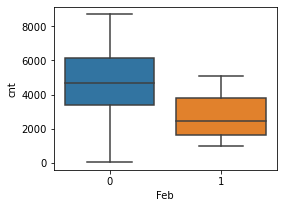

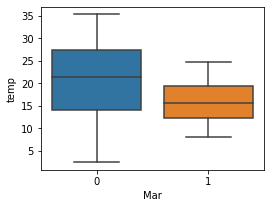

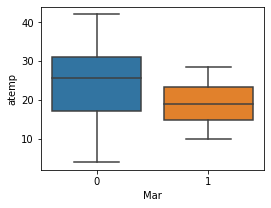

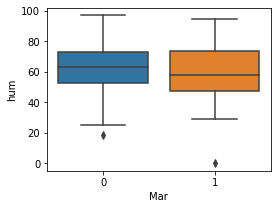

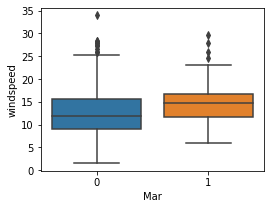

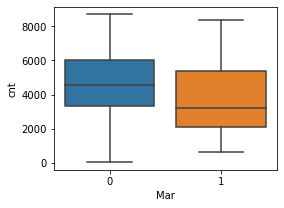

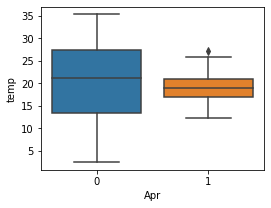

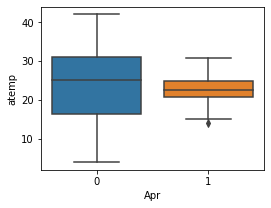

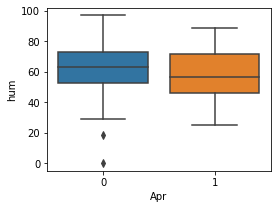

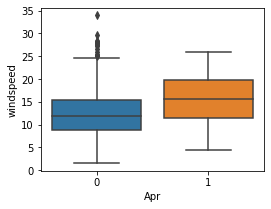

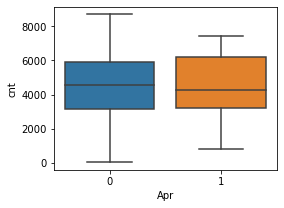

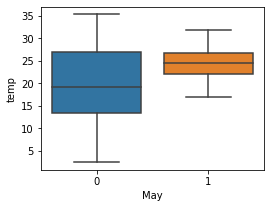

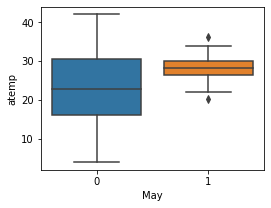

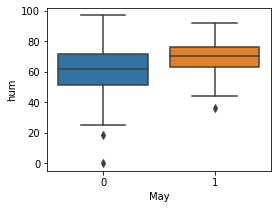

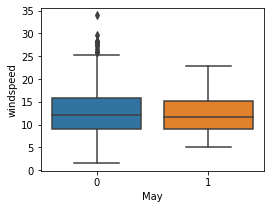

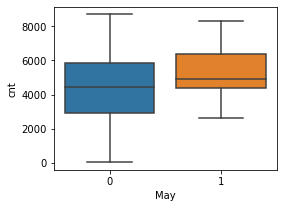

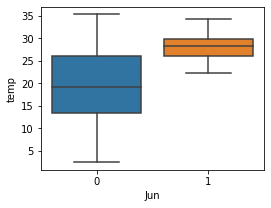

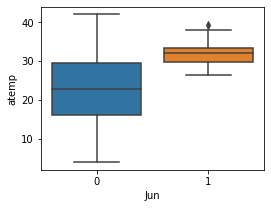

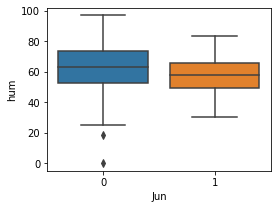

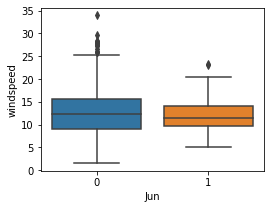

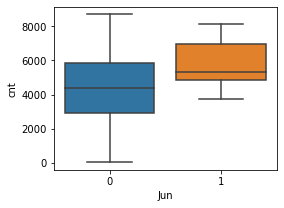

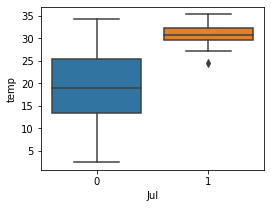

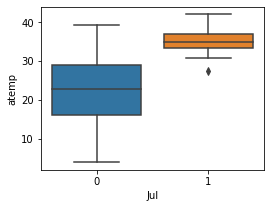

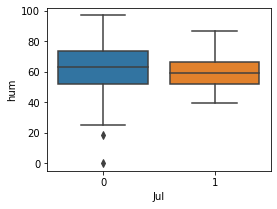

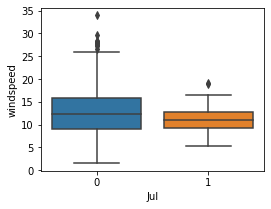

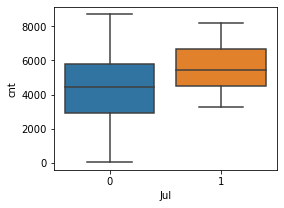

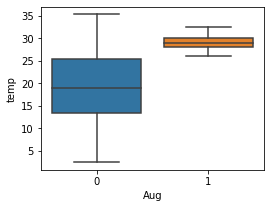

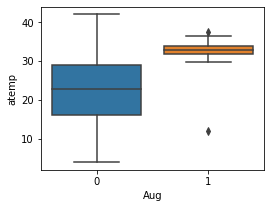

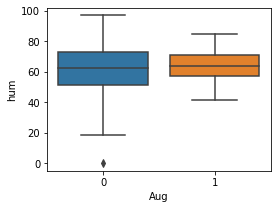

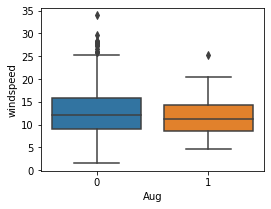

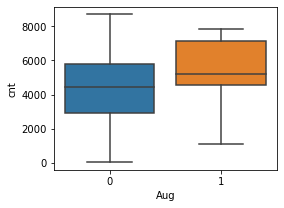

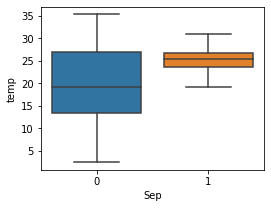

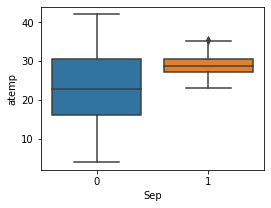

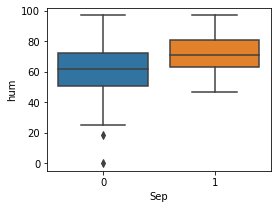

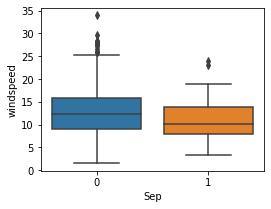

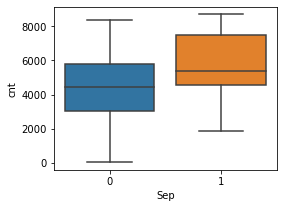

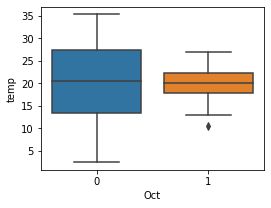

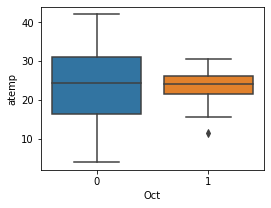

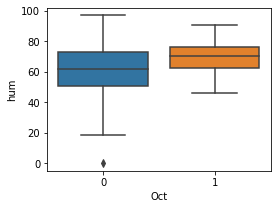

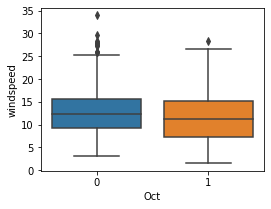

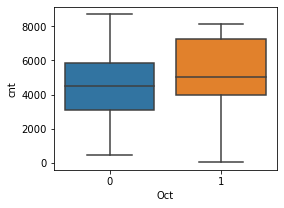

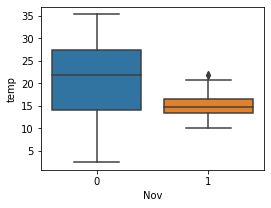

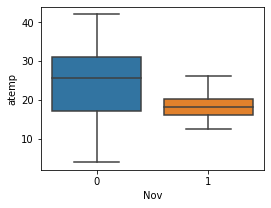

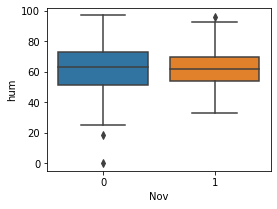

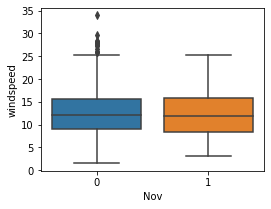

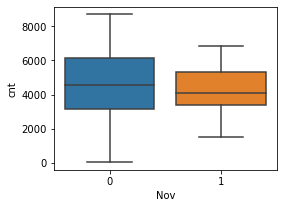

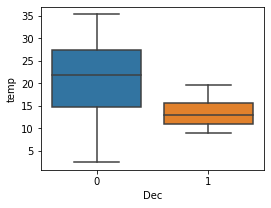

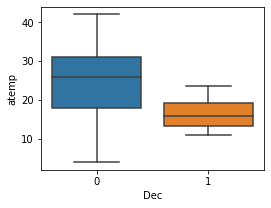

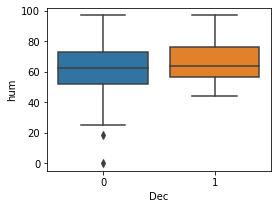

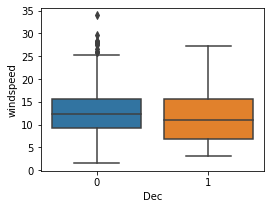

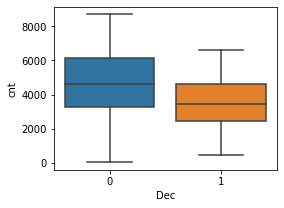

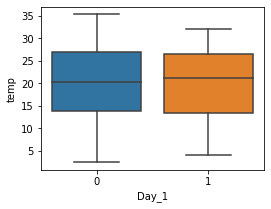

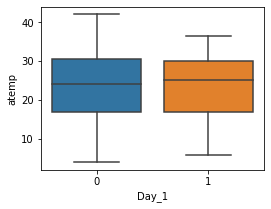

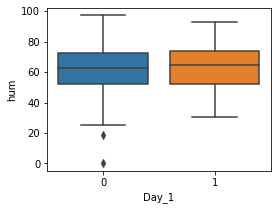

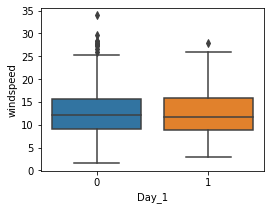

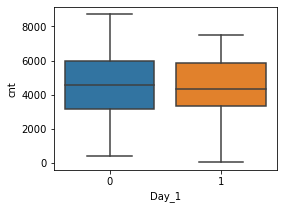

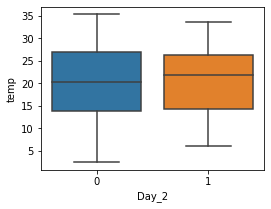

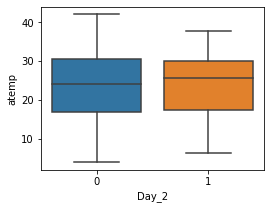

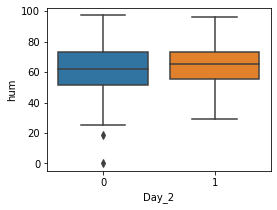

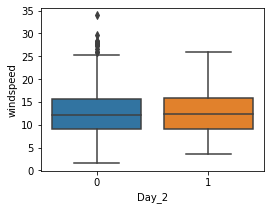

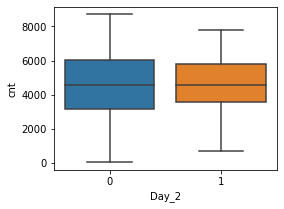

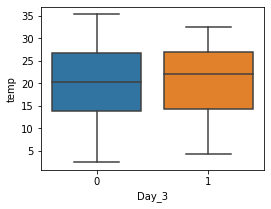

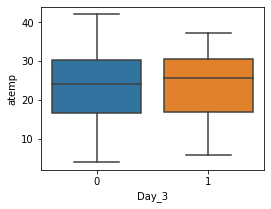

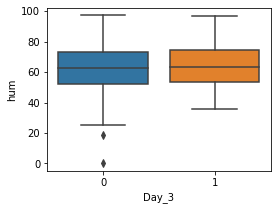

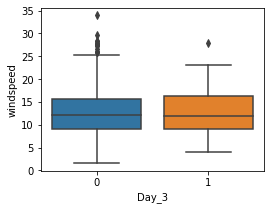

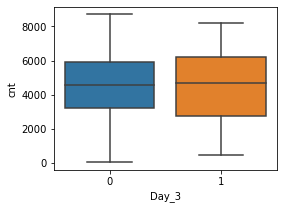

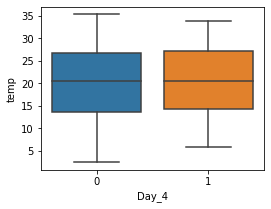

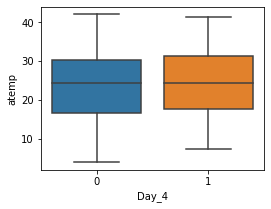

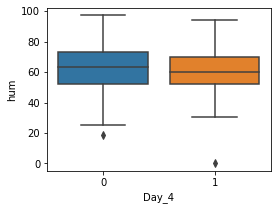

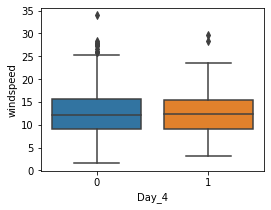

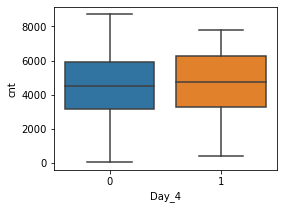

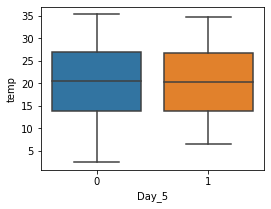

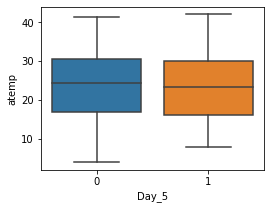

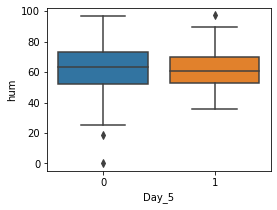

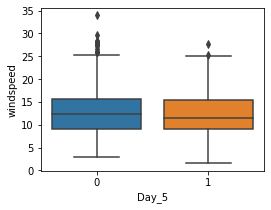

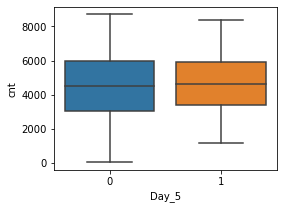

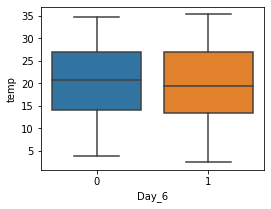

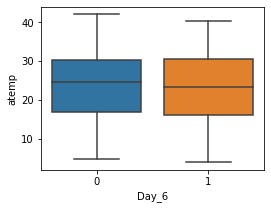

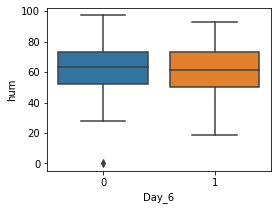

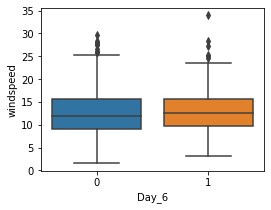

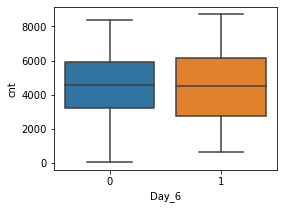

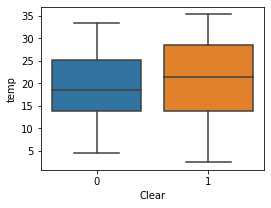

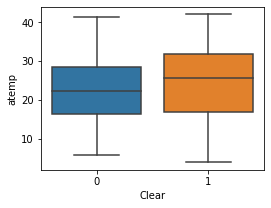

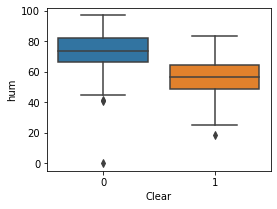

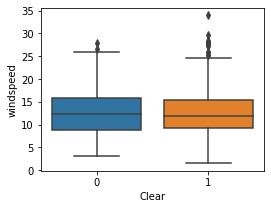

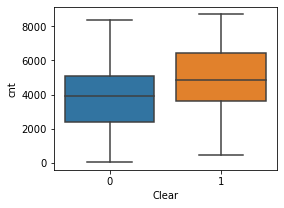

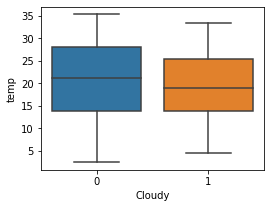

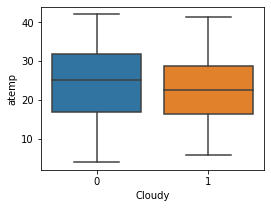

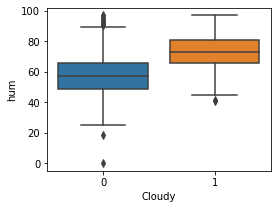

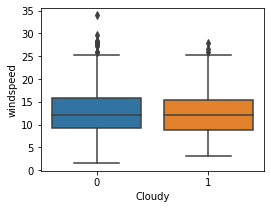

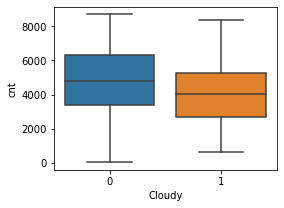

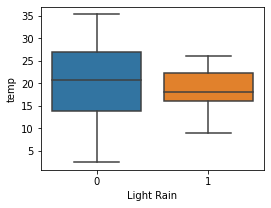

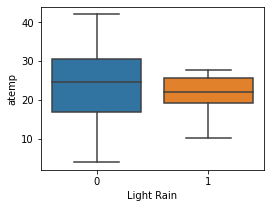

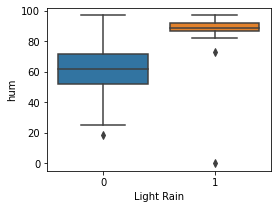

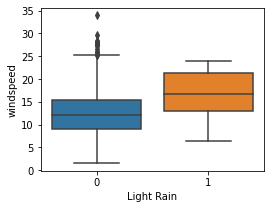

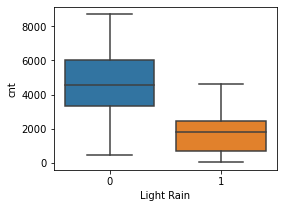

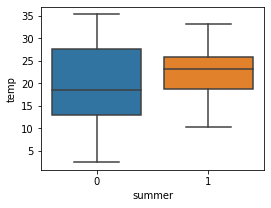

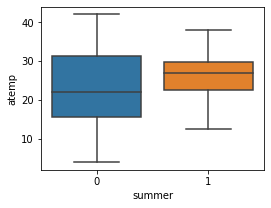

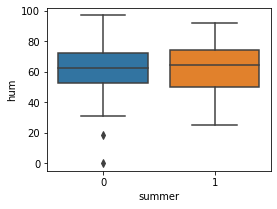

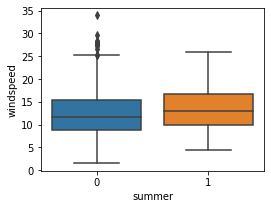

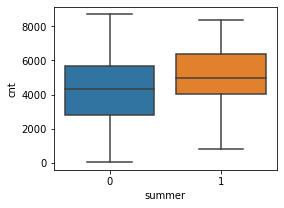

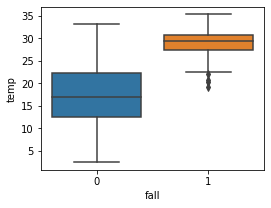

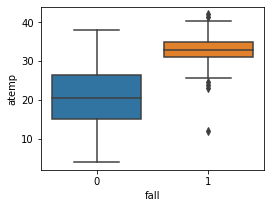

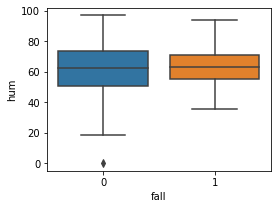

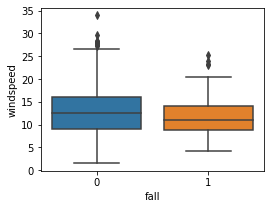

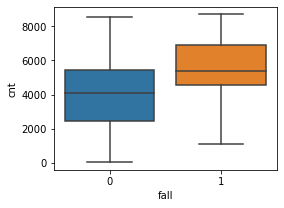

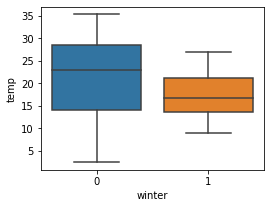

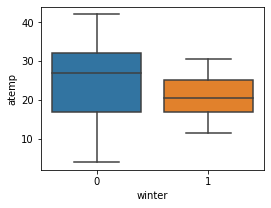

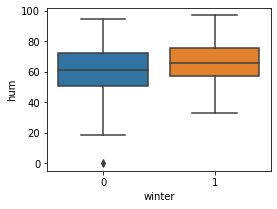

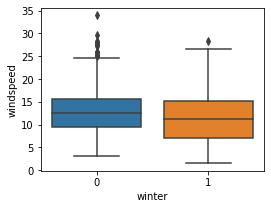

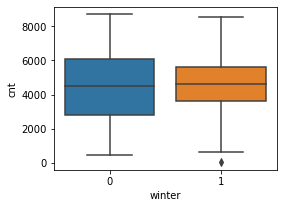

In [54]:
for col1 in cat_cols:
    for col2 in num_cols:
        plt.figure(figsize = (4,3))
        sns.boxplot(x=df_copy[col1],y=df_copy[col2])
        plt.show()

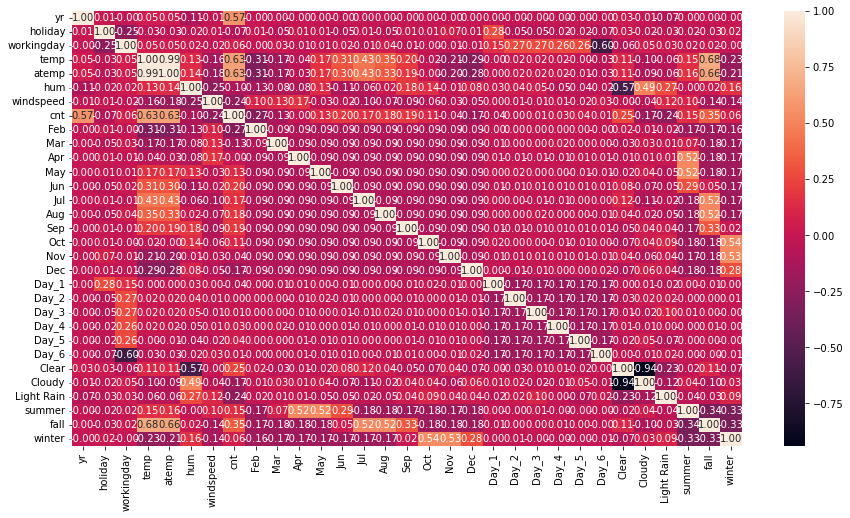

In [57]:
plt.figure(figsize=(15,8))
sns.heatmap(df_copy.corr(),annot=True,fmt='.2f')
plt.show()

Insights: 
- From the above heatmap of correlation, total bike rentals 'cnt' is highly correlated with 'temp', 'atemp' and 'yr'
- Columns 'temp' and 'atemp' are highly correlated among any two variables of the data set with almost similar data. 
- Among 'temp' and 'atemp', taking 'atemp' as the first dependent variable to build our model with target variable 'cnt' seems appropriate as feeling temperature is what drives a person to opt for a bike ride.


#### Scaling (Normalization)

In [62]:
scaler = MinMaxScaler()

In [64]:
cols_tobe_scaled = ['temp','atemp','hum','windspeed']
df_copy[cols_tobe_scaled] = scaler.fit_transform(df_copy[cols_tobe_scaled])

In [65]:
df_copy[num_cols]

,temp,atemp,hum,windspeed,cnt
0,0.355170,0.373517,0.828620,0.284606,985
1,0.379232,0.360541,0.715771,0.466215,801
2,0.171000,0.144830,0.449638,0.465740,1349
3,0.175530,0.174649,0.607131,0.284297,1562
4,0.209120,0.197158,0.449313,0.339143,1600
...,...,...,...,...,...
725,0.243025,0.193709,0.671380,0.675656,2114
726,0.241986,0.230993,0.606684,0.274350,3095
727,0.241986,0.214393,0.774208,0.210260,1341
728,0.245101,0.200348,0.497001,0.676936,1796


### Model Building
#### Simple Linear Regression

In [70]:
df_copy_tn, df_copy_ts = train_test_split(df_copy, train_size = 0.7, test_size = 0.3, random_state = 100)

In [78]:
df_copy_tn

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Feb,Mar,...,Day_3,Day_4,Day_5,Day_6,Clear,Cloudy,Light Rain,summer,fall,winter
653,1,0,1,0.509887,0.501133,0.574121,0.329497,7534,0,0,...,0,0,0,0,1,0,0,0,0,1
576,1,0,1,0.815169,0.766351,0.724079,0.294871,7216,0,0,...,0,0,0,0,1,0,0,0,1,0
426,1,0,0,0.442393,0.438975,0.638817,0.285911,4066,0,1,...,0,0,0,1,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.497001,0.676936,1796,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.503427,0.221789,4220,0,0,...,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,1,0,1,0.824514,0.762183,0.604542,0.382050,6664,0,0,...,0,0,0,0,0,1,0,1,0,0
578,1,0,1,0.863973,0.824359,0.678234,0.220508,7261,0,0,...,0,1,0,0,1,0,0,0,1,0
53,0,0,1,0.202618,0.218747,0.435006,0.147857,1917,1,0,...,1,0,0,0,1,0,0,0,0,0
350,0,0,0,0.248216,0.223544,0.576692,0.455140,2739,0,0,...,0,0,0,1,0,1,0,0,0,1


In [95]:
X_train = df_copy_tn['atemp']
y_train = df_copy_tn['cnt']
X_train_sm = sm.add_constant(X_train)

In [96]:
X_train_sm

,const,atemp
653,1.0,0.501133
576,1.0,0.766351
426,1.0,0.438975
728,1.0,0.200348
482,1.0,0.391735
...,...,...
526,1.0,0.762183
578,1.0,0.824359
53,1.0,0.218747
350,1.0,0.223544


In [97]:
slr = sm.OLS(y_train, X_train_sm)

In [98]:
slr_model = slr.fit() 

In [99]:
slr_model.params 

const    1438.132256
atemp    5942.135000
dtype: float64

In [100]:
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Wed, 17 Jan 2024   Prob (F-statistic):           1.10e-61
Time:                        22:57:19   Log-Likelihood:                -4449.3
No. Observations:                 510   AIC:                             8903.
Df Residuals:                     508   BIC:                             8911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1438.1323    172.721      8.326      0.000    1098.796    1777.469
atemp       5942.1350    311.133     19.098      0.000    5330.869    6553.401
==============================================================================
Omnibus:                        3.316   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                2.842
Skew:                           0.090   Prob(JB):                        0.241
Kurtosis:                       2.682   Cond. No.                         6.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
y_train_pred = slr_model.predict(X_train_sm)

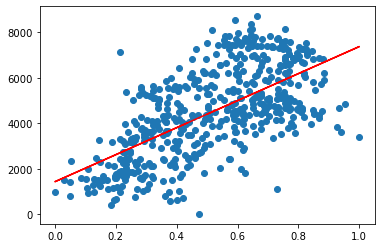

In [102]:
plt.scatter(X_train, y_train)
plt.plot(X_train, y_train_pred, 'r')
plt.show()

In [103]:
X_test = df_copy_ts['atemp']
y_test = df_copy_ts['cnt']
X_test_sm = sm.add_constant(X_test)

In [105]:
y_test_pred = slr_model.predict(X_test_sm)

In [106]:
r2_score(y_true=y_test, y_pred=y_test_pred)


0.3457229308751716

In [107]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.41793023963232967

Insights: 
- R-squared value is decent, around 41% variance in total bike rentals is explained by feeling temperature
- p-Value is almost zero and Prob(F-statistic) is less than 0.05 denoting the overall model is significant
- However, observing r2_score difference > 5%, building the model using other variables also might contribute in better understanding of total bike rentals

In [116]:
# Adding additional variables to X
X_train = df_copy_tn[['atemp','hum','windspeed']]

In [117]:
X_train

,atemp,hum,windspeed
653,0.501133,0.574121,0.329497
576,0.766351,0.724079,0.294871
426,0.438975,0.638817,0.285911
728,0.200348,0.497001,0.676936
482,0.391735,0.503427,0.221789
...,...,...,...
526,0.762183,0.604542,0.382050
578,0.824359,0.678234,0.220508
53,0.218747,0.435006,0.147857
350,0.223544,0.576692,0.455140


In [118]:
X_train_sm = sm.add_constant(X_train)
mlr1 = sm.OLS(y_train, X_train_sm)
mlr_model1 = mlr1.fit()

In [119]:
mlr_model1.params

const        4035.592594
atemp        5936.853653
hum         -2888.854486
windspeed   -2064.970122
dtype: float64

In [120]:
mlr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     152.1
Date:                Wed, 17 Jan 2024   Prob (F-statistic):           2.90e-70
Time:                        23:04:05   Log-Likelihood:                -4423.4
No. Observations:                 510   AIC:                             8855.
Df Residuals:                     506   BIC:                             8872.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4035.5926    389.454     10.362      0.000    3270.447    4800.738
atemp       5936.8537    305.584     19.428      0.000    5336.485    6537.223
hum        -2888.8545    451.779     -6.394      0.000   -3776.448   -2001.261
windspeed  -2064.9701    407.613     -5.066      0.000   -2865.793   -1264.147
==============================================================================
Omnibus:                        1.351   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.435
Skew:                           0.097   Prob(JB):                        0.488
Kurtosis:                       2.827   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
# Adding yr to X_train
X_train = df_copy_tn[['atemp','hum','windspeed','yr']]
X_train

,atemp,hum,windspeed,yr
653,0.501133,0.574121,0.329497,1
576,0.766351,0.724079,0.294871,1
426,0.438975,0.638817,0.285911,1
728,0.200348,0.497001,0.676936,1
482,0.391735,0.503427,0.221789,1
...,...,...,...,...
526,0.762183,0.604542,0.382050,1
578,0.824359,0.678234,0.220508,1
53,0.218747,0.435006,0.147857,0
350,0.223544,0.576692,0.455140,0


In [122]:
X_train_sm = sm.add_constant(X_train)
mlr2 = sm.OLS(y_train, X_train_sm)
mlr_model2 = mlr2.fit()

In [123]:
mlr_model2.params

const        2822.379103
atemp        5359.532907
hum         -2152.163828
windspeed   -2044.436195
yr           2016.604789
dtype: float64

In [125]:
mlr_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     351.3
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          2.38e-144
Time:                        23:05:30   Log-Likelihood:                -4248.0
No. Observations:                 510   AIC:                             8506.
Df Residuals:                     505   BIC:                             8527.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2822.3791    281.702     10.019      0.000    2268.928    3375.830
atemp       5359.5329    218.426     24.537      0.000    4930.397    5788.668
hum        -2152.1638    322.347     -6.677      0.000   -2785.471   -1518.857
windspeed  -2044.4362    289.312     -7.067      0.000   -2612.839   -1476.034
yr          2016.6048     90.237     22.348      0.000    1839.319    2193.890
==============================================================================
Omnibus:                       25.229   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.565
Skew:                          -0.421   Prob(JB):                     3.12e-08
Kurtosis:                       3.959   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Insights: 

- There seems to be a significant increase in R-squared value.
- p-value is still zero and prob(F-statistic) is also less than .05

Lets add few more independent variables to build the model

In [126]:
X_train = df_copy_tn[['atemp','hum','windspeed','yr','holiday']]
X_train

,atemp,hum,windspeed,yr,holiday
653,0.501133,0.574121,0.329497,1,0
576,0.766351,0.724079,0.294871,1,0
426,0.438975,0.638817,0.285911,1,0
728,0.200348,0.497001,0.676936,1,0
482,0.391735,0.503427,0.221789,1,0
...,...,...,...,...,...
526,0.762183,0.604542,0.382050,1,0
578,0.824359,0.678234,0.220508,1,0
53,0.218747,0.435006,0.147857,0,0
350,0.223544,0.576692,0.455140,0,0


In [128]:
X_train_sm = sm.add_constant(X_train)
mlr3 = sm.OLS(y_train, X_train_sm)
mlr_model3 = mlr3.fit()

In [129]:
mlr_model3.params

const        2862.717608
atemp        5329.463031
hum         -2164.706720
windspeed   -2045.565603
yr           2014.763621
holiday      -605.886171
dtype: float64

In [130]:
mlr_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     284.0
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          4.86e-144
Time:                        23:09:39   Log-Likelihood:                -4245.7
No. Observations:                 510   AIC:                             8503.
Df Residuals:                     504   BIC:                             8529.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2862.7176    281.337     10.175      0.000    2309.979    3415.456
atemp       5329.4630    218.106     24.435      0.000    4900.953    5757.973
hum        -2164.7067    321.262     -6.738      0.000   -2795.884   -1533.529
windspeed  -2045.5656    288.290     -7.096      0.000   -2611.964   -1479.168
yr          2014.7636     89.922     22.406      0.000    1838.095    2191.432
holiday     -605.8862    282.877     -2.142      0.033   -1161.649     -50.123
==============================================================================
Omnibus:                       24.723   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.159
Skew:                          -0.411   Prob(JB):                     3.82e-08
Kurtosis:                       3.966   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
# Adding 'Holiday' dint affect the model in a drastic way, adding 'workingday' to the model
X_train = df_copy_tn[['atemp','hum','windspeed','yr','holiday','workingday']]
X_train

,atemp,hum,windspeed,yr,holiday,workingday
653,0.501133,0.574121,0.329497,1,0,1
576,0.766351,0.724079,0.294871,1,0,1
426,0.438975,0.638817,0.285911,1,0,0
728,0.200348,0.497001,0.676936,1,0,0
482,0.391735,0.503427,0.221789,1,0,0
...,...,...,...,...,...,...
526,0.762183,0.604542,0.382050,1,0,1
578,0.824359,0.678234,0.220508,1,0,1
53,0.218747,0.435006,0.147857,0,0,1
350,0.223544,0.576692,0.455140,0,0,0


In [132]:
X_train_sm = sm.add_constant(X_train)
mlr4 = sm.OLS(y_train, X_train_sm)
mlr_model4 = mlr4.fit()

In [133]:
mlr_model4.params

const         2798.304660
atemp         5320.299797
hum          -2169.073885
windspeed    -2037.760914
yr            2012.369031
holiday       -536.655660
workingday     101.524055
dtype: float64

In [134]:
mlr_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     236.9
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          5.05e-143
Time:                        23:11:51   Log-Likelihood:                -4245.2
No. Observations:                 510   AIC:                             8504.
Df Residuals:                     503   BIC:                             8534.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2798.3047    288.101      9.713      0.000    2232.275    3364.334
atemp       5320.2998    218.270     24.375      0.000    4891.467    5749.132
hum        -2169.0739    321.266     -6.752      0.000   -2800.262   -1537.885
windspeed  -2037.7609    288.367     -7.067      0.000   -2604.313   -1471.209
yr          2012.3690     89.945     22.373      0.000    1835.655    2189.083
holiday     -536.6557    290.638     -1.846      0.065   -1107.669      34.357
workingday   101.5241     97.965      1.036      0.301     -90.946     293.995
==============================================================================
Omnibus:                       23.033   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.437
Skew:                          -0.381   Prob(JB):                     9.05e-08
Kurtosis:                       3.972   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
# again not much difference, so adding weather conditions
X_train = df_copy_tn[['atemp','hum','windspeed','yr','holiday','workingday','Clear','Cloudy','Light Rain']]
X_train

,atemp,hum,windspeed,yr,holiday,workingday,Clear,Cloudy,Light Rain
653,0.501133,0.574121,0.329497,1,0,1,1,0,0
576,0.766351,0.724079,0.294871,1,0,1,1,0,0
426,0.438975,0.638817,0.285911,1,0,0,0,1,0
728,0.200348,0.497001,0.676936,1,0,0,1,0,0
482,0.391735,0.503427,0.221789,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
526,0.762183,0.604542,0.382050,1,0,1,0,1,0
578,0.824359,0.678234,0.220508,1,0,1,1,0,0
53,0.218747,0.435006,0.147857,0,0,1,1,0,0
350,0.223544,0.576692,0.455140,0,0,0,0,1,0


In [136]:
X_train_sm = sm.add_constant(X_train)
mlr5 = sm.OLS(y_train, X_train_sm)
mlr_model5 = mlr5.fit()

In [137]:
mlr_model5.params

const          895.770012
atemp         5031.900631
hum           -614.580268
windspeed    -1615.830234
yr            2015.337424
holiday       -627.794963
workingday     130.145316
Clear         1110.787241
Cloudy         590.829593
Light Rain    -805.846823
dtype: float64

In [138]:
mlr_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     202.8
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          9.39e-152
Time:                        23:15:08   Log-Likelihood:                -4219.0
No. Observations:                 510   AIC:                             8456.
Df Residuals:                     501   BIC:                             8494.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        895.7700    264.108      3.392      0.001     376.875    1414.665
atemp       5031.9006    213.208     23.601      0.000    4613.008    5450.793
hum         -614.5803    389.024     -1.580      0.115   -1378.899     149.739
windspeed  -1615.8302    280.466     -5.761      0.000   -2166.865   -1064.796
yr          2015.3374     85.753     23.502      0.000    1846.858    2183.817
holiday     -627.7950    276.990     -2.266      0.024   -1172.000     -83.590
workingday   130.1453     93.359      1.394      0.164     -53.278     313.569
Clear       1110.7872     89.407     12.424      0.000     935.129    1286.445
Cloudy       590.8296    120.349      4.909      0.000     354.380     827.280
Light Rain  -805.8468    231.884     -3.475      0.001   -1261.432    -350.262
==============================================================================
Omnibus:                       13.081   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.622
Skew:                          -0.265   Prob(JB):                     0.000246
Kurtosis:                       3.708   Cond. No.                     8.75e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.07e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [144]:
# noticed p-value of 'workingday' and 'hum' is higher than 0.05 in both mlr4 and mlr5 so removing the same and creating a new model
X_train = df_copy_tn[['atemp','windspeed','yr','holiday','Clear','Cloudy','Light Rain']]
X_train

,atemp,windspeed,yr,holiday,Clear,Cloudy,Light Rain
653,0.501133,0.329497,1,0,1,0,0
576,0.766351,0.294871,1,0,1,0,0
426,0.438975,0.285911,1,0,0,1,0
728,0.200348,0.676936,1,0,1,0,0
482,0.391735,0.221789,1,0,0,1,0
...,...,...,...,...,...,...,...
526,0.762183,0.382050,1,0,0,1,0
578,0.824359,0.220508,1,0,1,0,0
53,0.218747,0.147857,0,0,1,0,0
350,0.223544,0.455140,0,0,0,1,0


In [145]:
X_train_sm = sm.add_constant(X_train)
mlr6 = sm.OLS(y_train, X_train_sm)
mlr_model6 = mlr6.fit()

In [146]:
mlr_model6.params

const          614.040245
atemp         4966.404775
windspeed    -1495.210195
yr            2031.982771
holiday       -725.331317
Clear         1104.896234
Cloudy         489.811141
Light Rain    -980.667130
dtype: float64

In [147]:
mlr_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     268.3
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          3.29e-153
Time:                        23:18:55   Log-Likelihood:                -4221.3
No. Observations:                 510   AIC:                             8457.
Df Residuals:                     503   BIC:                             8486.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        614.0402    136.535      4.497      0.000     345.790     882.290
atemp       4966.4048    207.508     23.934      0.000    4558.716    5374.093
windspeed  -1495.2102    268.256     -5.574      0.000   -2022.250    -968.170
yr          2031.9828     85.513     23.762      0.000    1863.976    2199.989
holiday     -725.3313    270.359     -2.683      0.008   -1256.503    -194.160
Clear       1104.8962     87.486     12.629      0.000     933.014    1276.778
Cloudy       489.8111     90.139      5.434      0.000     312.716     666.906
Light Rain  -980.6671    192.952     -5.082      0.000   -1359.758    -601.577
==============================================================================
Omnibus:                       16.237   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.299
Skew:                          -0.324   Prob(JB):                     3.91e-05
Kurtosis:                       3.732   Cond. No.                     8.81e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.46e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Using RFE to select features 

In [155]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [149]:
# Re-deviding X and y
y_train = df_copy_tn.pop('cnt')
X_train = df_copy_tn

In [157]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)

In [158]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 7),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Feb', False, 8),
 ('Mar', False, 3),
 ('Apr', False, 5),
 ('May', False, 4),
 ('Jun', False, 6),
 ('Jul', False, 9),
 ('Aug', True, 1),
 ('Sep', True, 1),
 ('Oct', True, 1),
 ('Nov', False, 10),
 ('Dec', False, 11),
 ('Day_1', False, 12),
 ('Day_2', False, 13),
 ('Day_3', False, 15),
 ('Day_4', False, 16),
 ('Day_5', False, 14),
 ('Day_6', True, 1),
 ('Clear', True, 1),
 ('Cloudy', True, 1),
 ('Light Rain', True, 1),
 ('summer', True, 1),
 ('fall', False, 2),
 ('winter', True, 1)]

In [159]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'Aug', 'Sep',
       'Oct', 'Day_6', 'Clear', 'Cloudy', 'Light Rain', 'summer', 'winter'],
      dtype='object')

In [160]:
X_train_rfe = X_train[col]

In [162]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [163]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [164]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     197.5
Date:                Wed, 17 Jan 2024   Prob (F-statistic):          3.24e-192
Time:                        23:31:27   Log-Likelihood:                -4106.6
No. Observations:                 510   AIC:                             8243.
Df Residuals:                     495   BIC:                             8307.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        669.8093    224.031      2.990      0.003     229.641    1109.978
yr          1991.8003     69.298     28.743      0.000    1855.646    2127.955
holiday     -485.4328    233.580     -2.078      0.038    -944.363     -26.503
workingday   385.5343    100.135      3.850      0.000     188.791     582.277
temp        4607.3314    190.890     24.136      0.000    4232.277    4982.386
hum        -1473.9506    321.800     -4.580      0.000   -2106.214    -841.688
windspeed  -1683.2900    228.752     -7.359      0.000   -2132.736   -1233.844
Aug          486.5873    139.913      3.478      0.001     211.691     761.484
Sep         1090.4246    140.103      7.783      0.000     815.155    1365.694
Oct          357.1657    148.641      2.403      0.017      65.121     649.210
Day_6        459.9928    126.138      3.647      0.000     212.160     707.826
Clear       1112.2361     74.559     14.918      0.000     965.746    1258.726
Cloudy       606.1301    100.133      6.053      0.000     409.392     802.868
Light Rain -1048.5569    190.349     -5.509      0.000   -1422.549    -674.564
summer       903.3425     93.319      9.680      0.000     719.992    1086.693
winter      1171.8277    103.558     11.316      0.000     968.360    1375.295
==============================================================================
Omnibus:                       71.668   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.034
Skew:                          -0.713   Prob(JB):                     2.96e-40
Kurtosis:                       5.555   Cond. No.                     1.15e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [168]:
y_test = df_copy_ts.pop('cnt')
X_test = df_copy_ts

In [169]:
X_test_rfe = X_test[col]

In [171]:
X_test_rfe = sm.add_constant(X_test_rfe)
y_test_pred = lm.predict(X_test_rfe)

In [173]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8139594321774225